# Bagian 1: Load Data

In [2]:
!pip install openpyxl
import pandas as pd

file = 'data_harga_kumulatif_malangkab_dan_cuaca_2022_2025_bersih.xlsx'
df = pd.read_excel(file)

print("DataFrame Harga:")
display(df.head())
print(df.info())

DataFrame Harga:


tanggal  malangkab    TN    TX  TAVG  RH_AVG     RR   SS  FF_X
0 2022-01-01      79000  20.4  29.0  24.3    82.0  25.10  3.4     3
1 2022-01-02      79000  20.4  28.6  24.1    82.0   6.40  3.0     3
2 2022-01-03      74000  20.7  29.4  24.4    80.0   2.90  4.1     4
3 2022-01-04      72000  20.2  28.6  24.1    81.0   1.85  7.3     5
4 2022-01-05      69000  19.6  28.8  24.3    78.0   0.80  4.1     5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   tanggal    1247 non-null   datetime64[ns]
 1   malangkab  1247 non-null   int64         
 2   TN         1247 non-null   float64       
 3   TX         1247 non-null   float64       
 4   TAVG       1247 non-null   float64       
 5   RH_AVG     1247 non-null   float64       
 6   RR         1247 non-null   float64       
 7   SS         1247 non-null   float64       
 8   FF_X       1247 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 87.8 KB
None


# Bagian 2: Eksplorasi Data

In [3]:
import pandas as pd

df['tanggal'] = pd.to_datetime(df['tanggal'])

df = df.rename(columns={'tanggal': 'ds', 'malangkab': 'y'})
other_columns = [col for col in df.columns if col not in ['ds', 'y']]

# Create a new DataFrame with the required columns in the desired order
df_prophet = df[['ds', 'y'] + other_columns].copy()

print("\nDataFrame for Prophet:")
display(df_prophet.head())
print(df_prophet.info())


DataFrame for Prophet:


ds      y    TN    TX  TAVG  RH_AVG     RR   SS  FF_X
0 2022-01-01  79000  20.4  29.0  24.3    82.0  25.10  3.4     3
1 2022-01-02  79000  20.4  28.6  24.1    82.0   6.40  3.0     3
2 2022-01-03  74000  20.7  29.4  24.4    80.0   2.90  4.1     4
3 2022-01-04  72000  20.2  28.6  24.1    81.0   1.85  7.3     5
4 2022-01-05  69000  19.6  28.8  24.3    78.0   0.80  4.1     5

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1247 non-null   datetime64[ns]
 1   y       1247 non-null   int64         
 2   TN      1247 non-null   float64       
 3   TX      1247 non-null   float64       
 4   TAVG    1247 non-null   float64       
 5   RH_AVG  1247 non-null   float64       
 6   RR      1247 non-null   float64       
 7   SS      1247 non-null   float64       
 8   FF_X    1247 non-null   int64         
dtypes: datetime64[ns](1), float64(6), int64(2)
memory usage: 87.8 KB
None


06:37:55 - cmdstanpy - INFO - Chain [1] start processing
06:37:55 - cmdstanpy - INFO - Chain [1] done processing


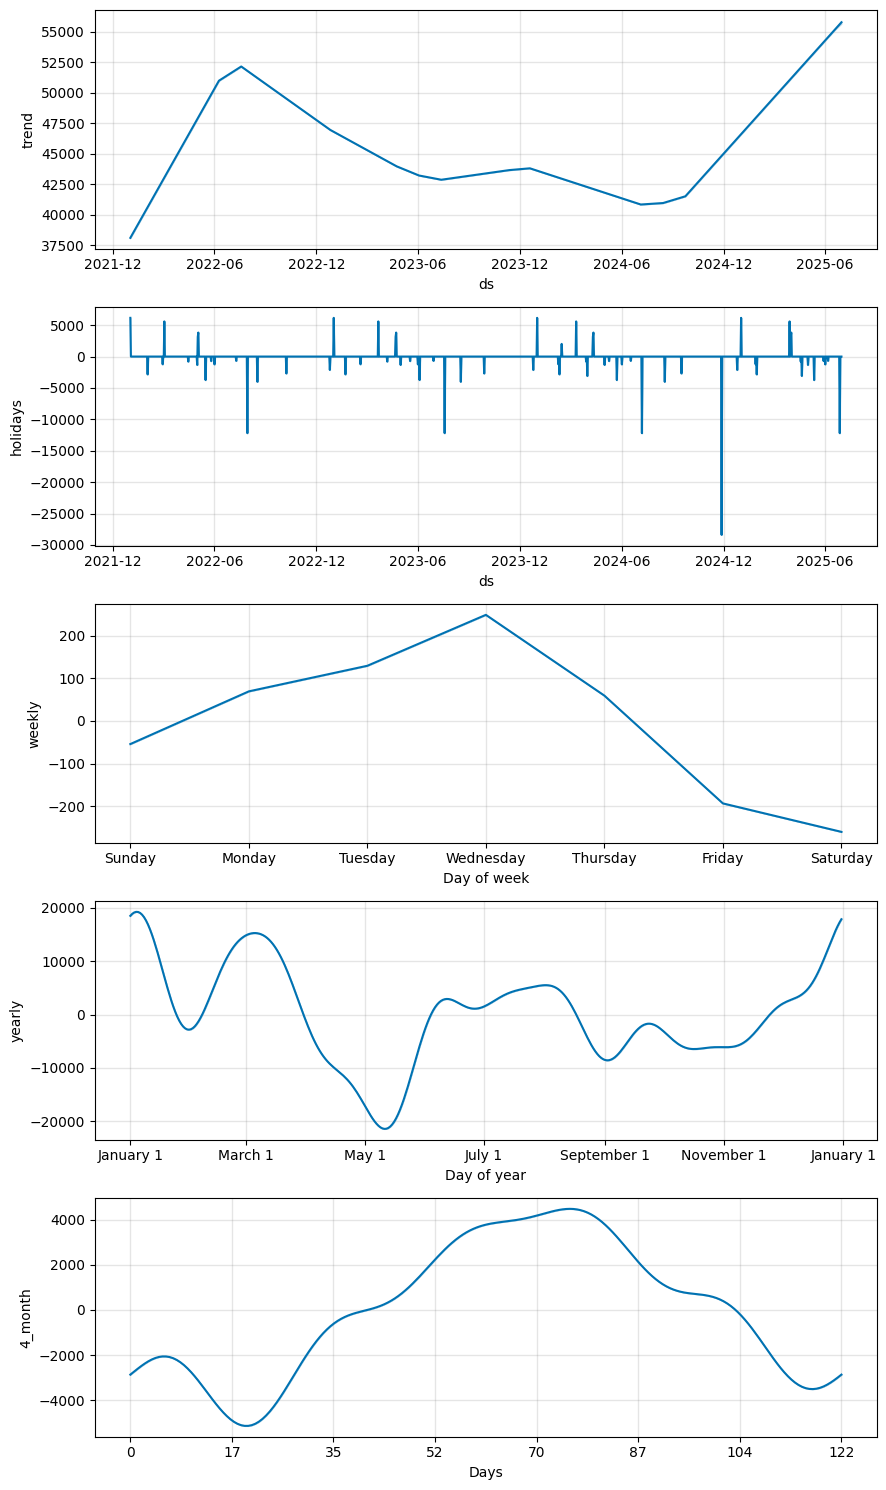

In [4]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt

model = Prophet()
model.add_seasonality(name='4_month', period=121.75, fourier_order=5)
model.add_country_holidays(country_name='ID')

model.fit(df_prophet)

future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

fig = model.plot_components(forecast)
plt.show()
fig.savefig('plot_tred_seasonality.png', dpi=300, bbox_inches='tight')

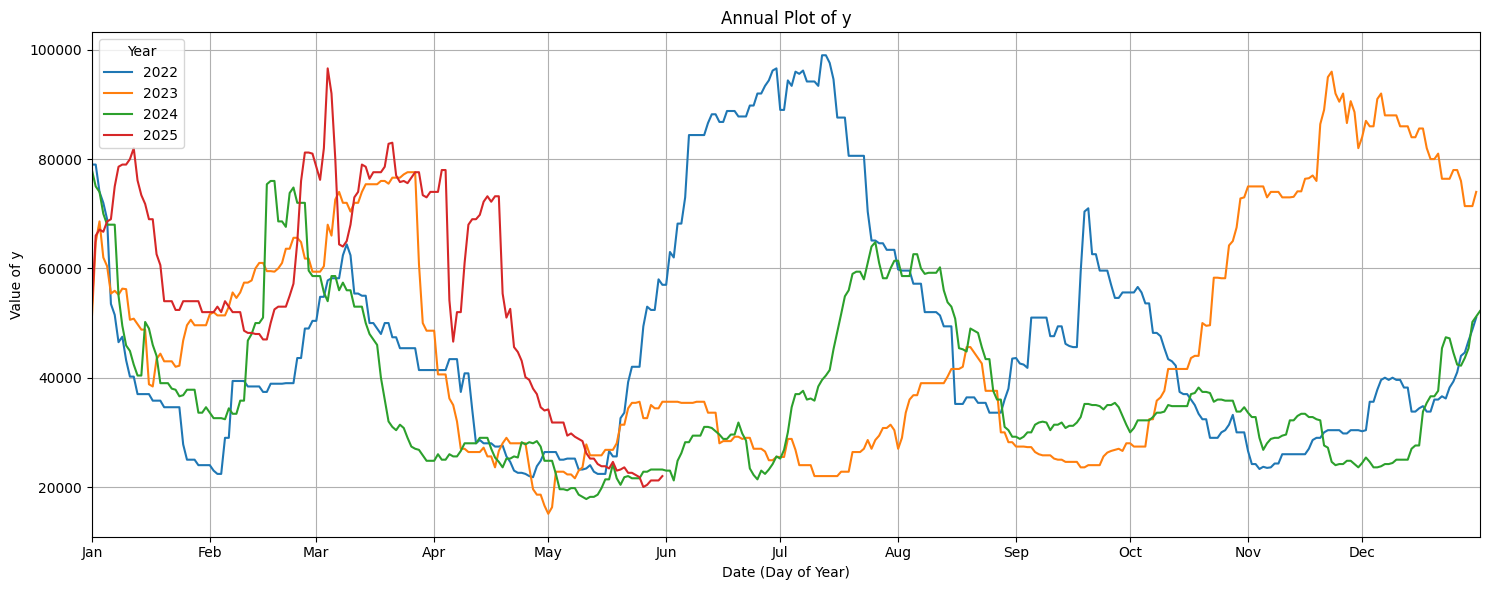

In [4]:
import matplotlib.pyplot as plt

df_prophet['year'] = df_prophet['ds'].dt.year
df_prophet['day_of_year'] = df_prophet['ds'].dt.dayofyear

plt.figure(figsize=(15, 6))

for year in df_prophet['year'].unique():
    df_year = df_prophet[df_prophet['year'] == year]
    plt.plot(df_year['day_of_year'], df_year['y'], label=str(year))

plt.xlim(1, 366)
month_days = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(month_days, month_labels)

plt.xlabel('Date (Day of Year)')
plt.ylabel('Value of y')
plt.title('Annual Plot of y')
plt.legend(title='Year')
plt.grid(True)
plt.tight_layout()

# Simpan ke file
plt.savefig('plot_seasonality_annual_exploratory.png', dpi=300, bbox_inches='tight')
plt.show()

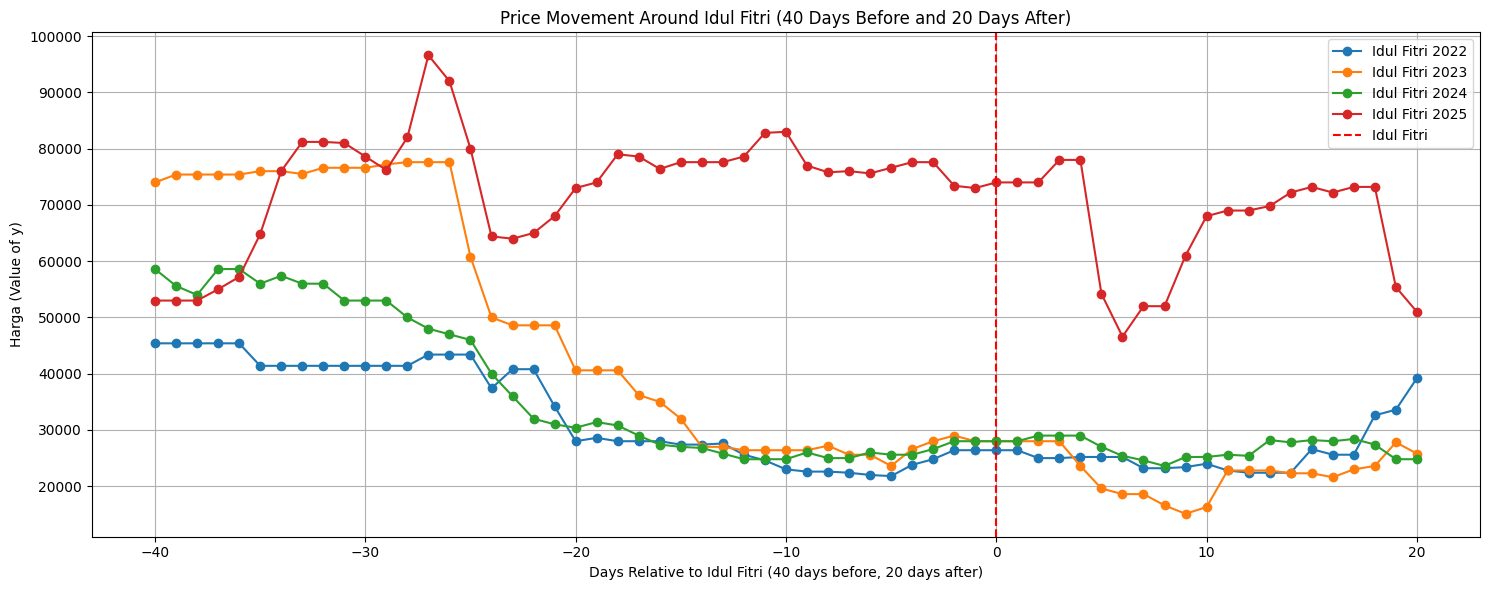

<Figure size 640x480 with 0 Axes>

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

idul_fitri_dates = {
    2022: '2022-05-02',
    2023: '2023-04-22',
    2024: '2024-04-10',
    2025: '2025-03-31'
}

for year, date_str in idul_fitri_dates.items():
    idul_fitri_dates[year] = pd.to_datetime(date_str)

days_before = 40
days_after = 20

plt.figure(figsize=(15, 6))

# Plot for each year
for year in sorted(idul_fitri_dates.keys()):
    if year in df_prophet['year'].unique():
        holiday_date = idul_fitri_dates[year]
        start_date = holiday_date - pd.Timedelta(days=days_before)
        end_date = holiday_date + pd.Timedelta(days=days_after)
        df_period = df_prophet[(df_prophet['ds'] >= start_date) & (df_prophet['ds'] <= end_date)].copy()

        if not df_period.empty:
            df_period['days_relative_to_holiday'] = (df_period['ds'] - holiday_date).dt.days
            plt.plot(df_period['days_relative_to_holiday'], df_period['y'], marker='o', linestyle='-', label=f'Idul Fitri {year}')

plt.axvline(0, color='red', linestyle='--', label='Idul Fitri')
plt.xlabel(f'Days Relative to Idul Fitri ({days_before} days before, {days_after} days after)')
plt.ylabel('Harga (Value of y)')
plt.title(f'Price Movement Around Idul Fitri ({days_before} Days Before and {days_after} Days After)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

plt.savefig('plot_around_idulfitri_exploratory.png', dpi=300, bbox_inches='tight')

Feature Engineering

In [5]:
df['RR7'] = df['RR'].rolling(window=7).sum().fillna(0)

# Threshold kondisi cuaca ekstrem
heat_stress_threshold = 32.0
warm_night_threshold = 22.0
heavy_rain_threshold = 50.0
high_humidity_threshold = 90.0
low_sunlight_threshold = 3.0

# misalnya < 4 jam dianggap rendah

# Hitung indeks cuaca ekstrem secara langsung
df['stress_idx'] = (
    (df_prophet['TX'] > heat_stress_threshold).astype(int) +     # heat stress
    (df_prophet['TN'] > warm_night_threshold).astype(int) +      # warm night
    (df_prophet['RR'] > heavy_rain_threshold).astype(int) +      # heavy rain
    (df_prophet['RH_AVG'] > high_humidity_threshold).astype(int) + # high humidity
    (df_prophet['SS'] < low_sunlight_threshold).astype(int)      # low sunlight
)

df['stress_idx7'] = df['stress_idx'].rolling(window=7).sum().fillna(0)

In [6]:
regressor_cols = [col for col in df.columns if col not in ['ds', 'y']]
vars_to_analyze = ['y'] + regressor_cols

stats_df = df[vars_to_analyze].describe(percentiles=[.25, .5, .75])
stats_df = stats_df.rename(index={
    'mean': 'Rata-rata',
    'std': 'Standard Deviation',
    'min': 'Minimum',
    '25%': '25%',
    '50%': '50%',
    '75%': '75%',
    'max': 'Maximum'
}).round(2)
print("\nStatistik Utama Variabel Target (Harga) dan Regresor:")
display(stats_df)



Statistik Utama Variabel Target (Harga) dan Regresor:


y       TN       TX     TAVG   RH_AVG       RR  \
count                1247.00  1247.00  1247.00  1247.00  1247.00  1247.00   
Rata-rata           45232.53    20.25    29.40    24.55    78.31     6.71   
Standard Deviation  19884.66     1.43     1.41     1.27     7.36    14.11   
Minimum             15100.00    14.60    24.50    20.10    50.00     0.00   
25%                 28600.00    19.60    28.60    23.70    74.00     0.00   
50%                 39000.00    20.40    29.40    24.40    79.00     0.25   
75%                 58200.00    21.20    30.20    25.40    84.00     5.75   
Maximum             99000.00    24.80    34.00    28.80    96.00   105.40   

                         SS     FF_X      RR7  stress_idx  stress_idx7  
count               1247.00  1247.00  1247.00     1247.00      1247.00  
Rata-rata              5.80     4.42    46.78        0.32         2.24  
Standard Deviation     2.77     1.27    50.78        0.54         2.22  
Minimum                0.00     2.00     0.00        0.00         0.00  
25%                    3.80     4.00     2.90        0.00         0.00  
50%                    6.20     4.00    30.60        0.00         2.00  
75%                    8.00     5.00    71.55        1.00         3.00  
Maximum               11.30    15.00   243.80        3.00        10.00

Tabel Korelasi Spearman terhadap Harga (y):


Regresor  Spearman Correlation   p-value
0          RR7                 0.218  6.09e-15
1   stress_idx                 0.107  0.000148
2  stress_idx7                 0.205  2.49e-13

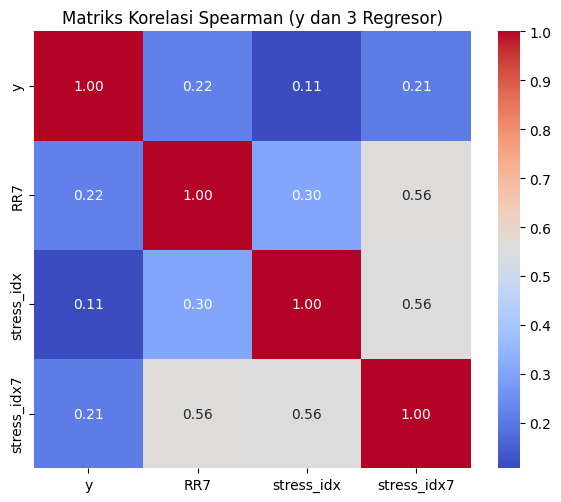


Tabel Korelasi Pearson terhadap Harga (y):


Regresor  Pearson Correlation   p-value
0          RR7                0.190  1.18e-11
1   stress_idx                0.089   0.00159
2  stress_idx7                0.182  1.06e-10

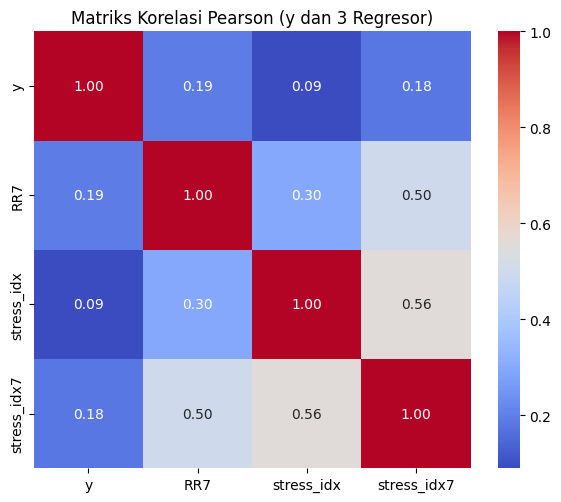

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import pandas as pd

# Variabel yang ingin dianalisis korelasinya terhadap y
regressors = ['RR7', 'stress_idx', 'stress_idx7']
vars_for_corr = ['y'] + regressors

# SPEARMAN ----------------------------------------------------------------------
# Hitung matriks korelasi dan p-value Spearman
corr_matrix, p_matrix = spearmanr(df[vars_for_corr])

# Buat DataFrame untuk korelasi dan p-value
corr_df = pd.DataFrame(corr_matrix, index=vars_for_corr, columns=vars_for_corr)
pval_df = pd.DataFrame(p_matrix, index=vars_for_corr, columns=vars_for_corr)

# Ekstrak korelasi dan p-value terhadap target y
summary = []
for var in regressors:
    coef = corr_df.loc['y', var]
    pval = pval_df.loc['y', var]
    summary.append({
        'Regresor': var,
        'Spearman Correlation': round(coef, 3),
        'p-value': f"{pval:.3g}"
    })
df_corr_summary = pd.DataFrame(summary)

# Tampilkan tabel hasil Spearman
print("Tabel Korelasi Spearman terhadap Harga (y):")
display(df_corr_summary)

# Visualisasi Heatmap Korelasi Spearman
plt.figure(figsize=(6, 5))
sns.heatmap(
    corr_df.loc[vars_for_corr, vars_for_corr],
    annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True
)
plt.title("Matriks Korelasi Spearman (y dan 3 Regresor)")
plt.tight_layout()
plt.savefig("correlation_spearman_selected.png", dpi=300, bbox_inches='tight')
plt.show()


# PEARSON ----------------------------------------------------------------------
# Hitung matriks korelasi dan p-value Pearson
pearson_corr = df[vars_for_corr].corr(method='pearson')
pearson_pval = df[vars_for_corr].corr(method=lambda x, y: pearsonr(x, y)[1])  # Hitung p-value pairwise

# Ekstrak nilai korelasi dan p-value terhadap y
summary_pearson = []
for var in regressors:
    coef = pearson_corr.loc['y', var]
    pval = pearson_pval.loc['y', var]
    summary_pearson.append({
        'Regresor': var,
        'Pearson Correlation': round(coef, 3),
        'p-value': f"{pval:.3g}"
    })
df_corr_pearson = pd.DataFrame(summary_pearson)

# Tampilkan tabel hasil Pearson
print("\nTabel Korelasi Pearson terhadap Harga (y):")
display(df_corr_pearson)

# Visualisasi Heatmap Korelasi Pearson
plt.figure(figsize=(6, 5))
sns.heatmap(
    pearson_corr.loc[vars_for_corr, vars_for_corr],
    annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar=True
)
plt.title("Matriks Korelasi Pearson (y dan 3 Regresor)")
plt.tight_layout()
plt.savefig("correlation_pearson_selected.png", dpi=300, bbox_inches='tight')
plt.show()



Analisis Korelasi Spearman dengan Lag
Lag Optimal dan Korelasi Terbaik:
  - RR7:
    - Lag Optimal    : 0 hari
    - Korelasi       : 0.2185
    - p-value        : 0.0000
  - stress_idx:
    - Lag Optimal    : 27 hari
    - Korelasi       : 0.1933
    - p-value        : 0.0000
  - stress_idx7:
    - Lag Optimal    : 23 hari
    - Korelasi       : 0.3032
    - p-value        : 0.0000


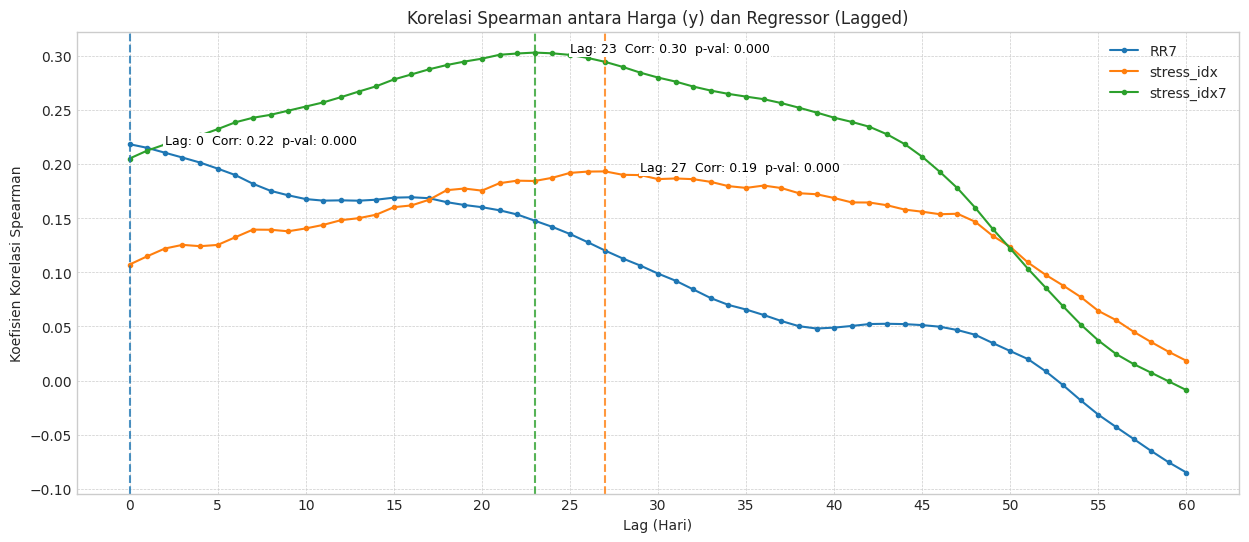


Analisis Korelasi Pearson dengan Lag
Lag Optimal dan Korelasi Terbaik:
  - RR7:
    - Lag Optimal    : 1 hari
    - Korelasi       : 0.1919
    - p-value        : 0.0000
  - stress_idx:
    - Lag Optimal    : 25 hari
    - Korelasi       : 0.2056
    - p-value        : 0.0000
  - stress_idx7:
    - Lag Optimal    : 24 hari
    - Korelasi       : 0.3362
    - p-value        : 0.0000


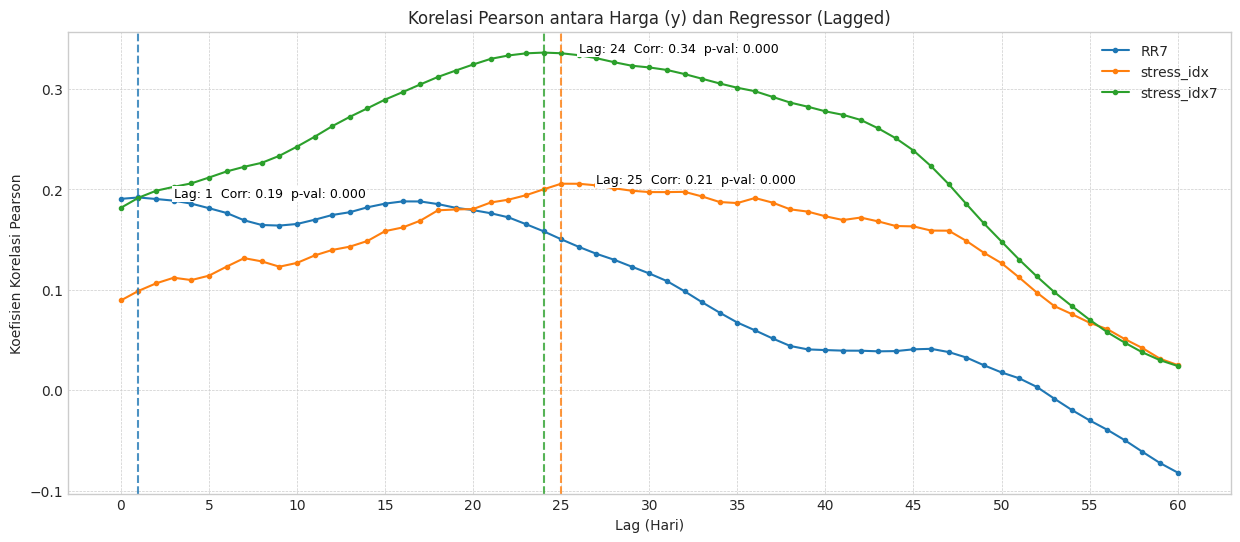

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr

def analyze_lagged_correlation(df, target_col, regressors, lags, method='spearman'):
    """
    Fungsi untuk menganalisis, memvisualisasikan, dan melaporkan korelasi
    yang digeser (lagged) antara satu target dan beberapa regressor.
    
    Args:
        df (pd.DataFrame): DataFrame berisi data.
        target_col (str): Nama kolom target (misal: 'y').
        regressors (list): Daftar nama kolom regressor yang akan dianalisis.
        lags (range): Rentang lag yang akan diuji (misal: range(101)).
        method (str): Metode korelasi, 'spearman' atau 'pearson'.
    """
    # 1. Pilih fungsi korelasi berdasarkan metode
    corr_func = spearmanr if method == 'spearman' else pearsonr
    print(f"\n{'='*40}\nAnalisis Korelasi {method.title()} dengan Lag\n{'='*40}")

    # 2. Hitung korelasi untuk setiap regressor dan lag
    correlation_results = {}
    for reg in regressors:
        corrs = [corr_func(df[target_col], df[reg].shift(lag).fillna(0))[0] for lag in lags]
        correlation_results[reg] = corrs
    
    corr_df = pd.DataFrame(correlation_results, index=lags)

    # 3. Temukan lag terbaik dan hitung p-value-nya
    best_lags_info = {}
    for reg in regressors:
        # Temukan lag dengan nilai korelasi absolut tertinggi
        best_lag = corr_df[reg].abs().idxmax()
        best_corr = corr_df.loc[best_lag, reg]
        
        # Hitung p-value hanya untuk lag terbaik
        temp_df = pd.DataFrame({target_col: df[target_col], reg: df[reg].shift(best_lag)}).dropna()
        _, p_value = corr_func(temp_df[target_col], temp_df[reg])
        
        best_lags_info[reg] = {
            'lag': best_lag,
            'correlation': best_corr,
            'p_value': p_value
        }

    # 4. Tampilkan hasil lag terbaik
    print("Lag Optimal dan Korelasi Terbaik:")
    for reg, info in best_lags_info.items():
        print(f"  - {reg}:")
        print(f"    - Lag Optimal    : {info['lag']} hari")
        print(f"    - Korelasi       : {info['correlation']:.4f}")
        print(f"    - p-value        : {info['p_value']:.4f}")

    # 5. Visualisasi
    plt.style.use('seaborn-v0_8-whitegrid')
    plt.figure(figsize=(15, 6))
    
    for reg in regressors:
        plt.plot(corr_df.index, corr_df[reg], marker='.', linestyle='-', label=reg)

    # Tandai lag terbaik dengan garis dan teks
    for reg, info in best_lags_info.items():
        line = plt.gca().lines[regressors.index(reg)]
        plt.axvline(x=info['lag'], color=line.get_color(), linestyle='--', alpha=0.8)
        plt.text(
            info['lag'] + 2, info['correlation'], 
            f"Lag: {info['lag']}  Corr: {info['correlation']:.2f}  p-val: {info['p_value']:.3f}",
            fontsize=9,
            color='black',  # teks hitam agar jelas terbaca
            bbox=dict(facecolor='white', edgecolor='none', alpha=1, pad=1)  # background putih solid tanpa transparansi
        )



    plt.title(f'Korelasi {method.title()} antara Harga (y) dan Regressor (Lagged)')
    plt.xlabel('Lag (Hari)')
    plt.ylabel(f'Koefisien Korelasi {method.title()}')
    plt.xticks(np.arange(min(lags), max(lags)+1, 5))
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.show()


# --- Eksekusi Kode ---
# Asumsi df_prophet sudah ada dan terdefinisi

# 1. Tentukan kolom dan rentang lag yang akan dianalisis
regressors_to_analyze = ['RR7', 'stress_idx', 'stress_idx7']
lags_to_check = range(61) # Lag 0 sampai 100 hari

# 2. Jalankan analisis untuk Spearman
analyze_lagged_correlation(df, 'y', regressors_to_analyze, lags_to_check, method='spearman')

# 3. Jalankan analisis untuk Pearson
analyze_lagged_correlation(df, 'y', regressors_to_analyze, lags_to_check, method='pearson')

# Bagian 3: Pembagian Data

In [9]:
# Lakukan pelagangan (lagging) sebelum pembagian data
df['stress_idx7_lag23'] = df['stress_idx7'].shift(23).fillna(0)

# Pilih hanya kolom yang dibutuhkan
selected_cols = ['ds', 'y', 'RR7', 'stress_idx7_lag23']

# Bagi data
df_tscv = df[df['ds'] <= '2025-03-31'][selected_cols].copy()
df_pred = df[(df['ds'] >= '2022-01-01') & (df['ds'] <= '2025-05-31')][selected_cols].copy()

# Cek hasil
print("\nInfo DataFrame untuk TSCV (df_tscv):")
print(df_tscv.info())

print("\nInfo DataFrame untuk Prediksi Rolling Origin (df_pred):")
print(df_pred.info())

regressor_cols = [col for col in df_tscv.columns if col not in ['ds', 'y']]
vars_to_analyze = ['y'] + regressor_cols

stats_df = df_tscv[vars_to_analyze].describe(percentiles=[.25, .5, .75])
stats_df = stats_df.rename(index={
    'mean': 'Rata-rata',
    'std': 'Standard Deviation',
    'min': 'Minimum',
    '25%': '25%',
    '50%': '50%',
    '75%': '75%',
    'max': 'Maximum'
}).round(2)
print("\nStatistik Utama Data TSCV Variabel Target (Harga) dan Regresor:")
display(stats_df)

regressor_cols = [col for col in df_pred.columns if col not in ['ds', 'y']]
vars_to_analyze = ['y'] + regressor_cols

stats_df = df_pred[vars_to_analyze].describe(percentiles=[.25, .5, .75])
stats_df = stats_df.rename(index={
    'mean': 'Rata-rata',
    'std': 'Standard Deviation',
    'min': 'Minimum',
    '25%': '25%',
    '50%': '50%',
    '75%': '75%',
    'max': 'Maximum'
}).round(2)
print("\nStatistik Utama Data Prediksi Variabel Target (Harga) dan Regresor:")
display(stats_df)



Info DataFrame untuk TSCV (df_tscv):
<class 'pandas.core.frame.DataFrame'>
Index: 1186 entries, 0 to 1185
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 1186 non-null   datetime64[ns]
 1   y                  1186 non-null   int64         
 2   RR7                1186 non-null   float64       
 3   stress_idx7_lag23  1186 non-null   float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 46.3 KB
None

Info DataFrame untuk Prediksi Rolling Origin (df_pred):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247 entries, 0 to 1246
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   ds                 1247 non-null   datetime64[ns]
 1   y                  1247 non-null   int64         
 2   RR7                1247 non-null   float64       
 3   stress_idx7_l

y      RR7  stress_idx7_lag23
count                1186.00  1186.00            1186.00
Rata-rata           45439.51    47.19               2.21
Standard Deviation  19895.88    51.13               2.23
Minimum             15100.00     0.00               0.00
25%                 28800.00     2.52               0.00
50%                 39000.00    31.50               2.00
75%                 58200.00    72.39               3.00
Maximum             99000.00   243.80              10.00


Statistik Utama Data Prediksi Variabel Target (Harga) dan Regresor:


y      RR7  stress_idx7_lag23
count                1247.00  1247.00            1247.00
Rata-rata           45232.53    46.78               2.19
Standard Deviation  19884.66    50.78               2.22
Minimum             15100.00     0.00               0.00
25%                 28600.00     2.90               0.00
50%                 39000.00    30.60               2.00
75%                 58200.00    71.55               3.00
Maximum             99000.00   243.80              10.00

# Bagian 4: Perancangan Model

In [10]:
!pip install optuna
!pip install prophet
!pip install cmdstanpy
!pip install -U kaleido

TSCV Model Baseline 1 hari

Trial 200/200
Optimasi Selesai.
Ditemukan 7 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1    85  7435.878842  4107.107886  16.285286  0.465     15   0.55   
1     2   187  7239.338207  4141.686834  16.016905  0.465     14   0.60   
2     3   188  7149.606535  4321.518774  15.649908  0.460     14   0.65   
3     4   118  6762.659553  4356.878260  14.447869  0.490     15   1.90   
4     5    68  6691.614311  4367.053246  14.406908  0.500     12   1.30   
5     6   195  6512.447353  4393.301510  14.027019  0.465     15   9.65   
6     7    62  6482.842062  5033.024313  13.966838  0.500     10   6.10   

   fo121  ps121  fo7   ps7   skor_cv  
0      8   0.05    8  8.80  0.552337  
1      7   0.30    7  8.65  0.572108  
2      7   0.25    8  8.80  0.604441  
3      8   2.15   11  8.00  0.644255  
4      8   0.65   10  8.20  0.652616  
5      7   0.25    7  6.40  0.674601  
6      7   2.65    9  8.20  0.776361


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


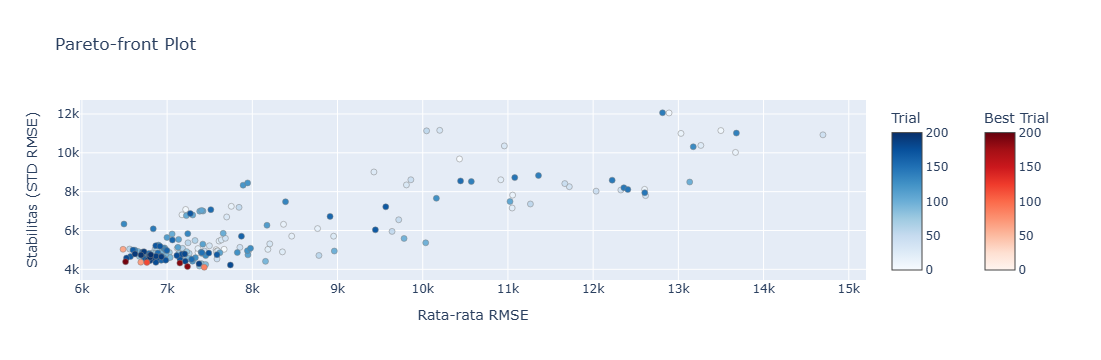

In [82]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Baseline 1D

Parameter yang digunakan:


rank   iter     rmse_avg    std_rmse       mape    cps  fo365  ps365  \
5   6.0  195.0  6512.447353  4393.30151  14.027019  0.465   15.0   9.65   

   fo121  ps121  fo7  ps7   skor_cv  
5    7.0   0.25  7.0  6.4  0.674601


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 8009 ± 5215, MAPE = 20.00%
File metrik per-fold telah disimpan.


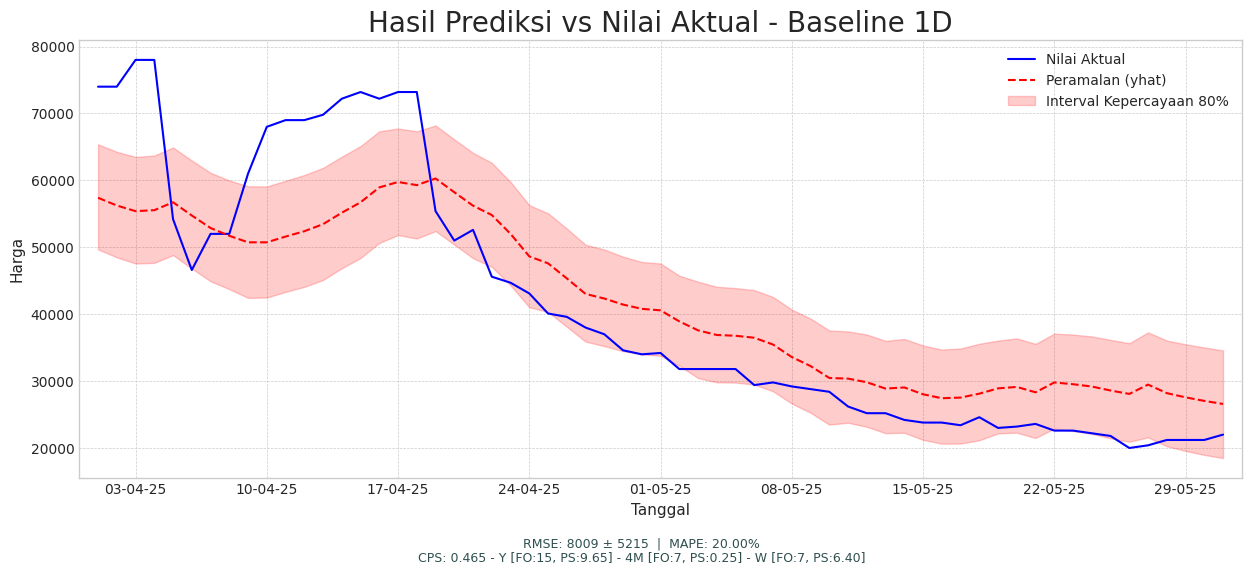

In [16]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[5]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Model Baseline 7D

Trial 200/200
Optimasi Selesai.
Ditemukan 6 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   189  9821.961614  5126.609022  20.842240  0.410     14   4.50   
1     2    77  9511.299120  5700.175404  20.021838  0.500     10   9.15   
2     3    58  9393.521618  6192.082644  19.463161  0.405     11   8.40   
3     4    91  9284.219845  6446.290629  19.151808  0.365      8   7.80   
4     5    90  8635.933056  7144.954053  17.164767  0.360      8   5.05   
5     6    89  8604.707030  8093.859647  16.761664  0.370      8   7.65   

   fo121  ps121  fo7   ps7   skor_cv  
0      1   6.95   14  9.65  0.521954  
1      5   3.75   10  7.50  0.599306  
2      6   9.85    9  3.75  0.659187  
3      1   3.90   14  0.30  0.694328  
4      1   3.85   14  0.10  0.827352  
5      3   3.85   14  0.05  0.940632


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


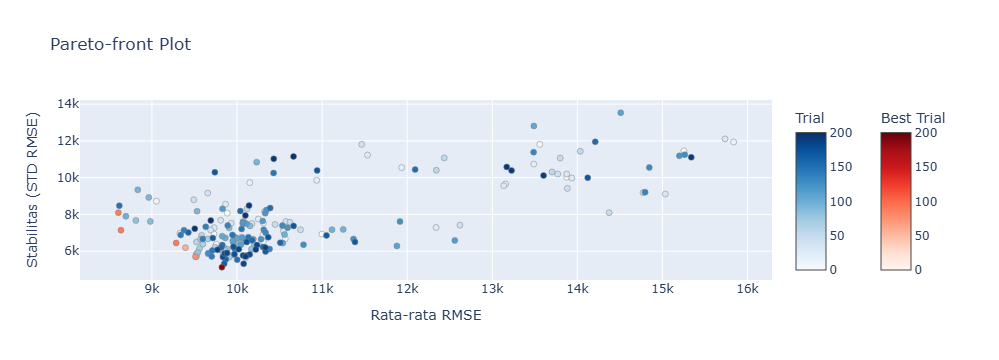

In [92]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON = "7d"
HORIZON_STR = "7 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Baseline 7D

Parameter yang digunakan:


rank   iter     rmse_avg     std_rmse      mape   cps  fo365  ps365  fo121  \
0   1.0  189.0  9821.961614  5126.609022  20.84224  0.41   14.0    4.5    1.0   

   ps121   fo7   ps7   skor_cv  
0   6.95  14.0  9.65  0.521954


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 11389 ± 4923, MAPE = 27.88%
File metrik per-fold telah disimpan.


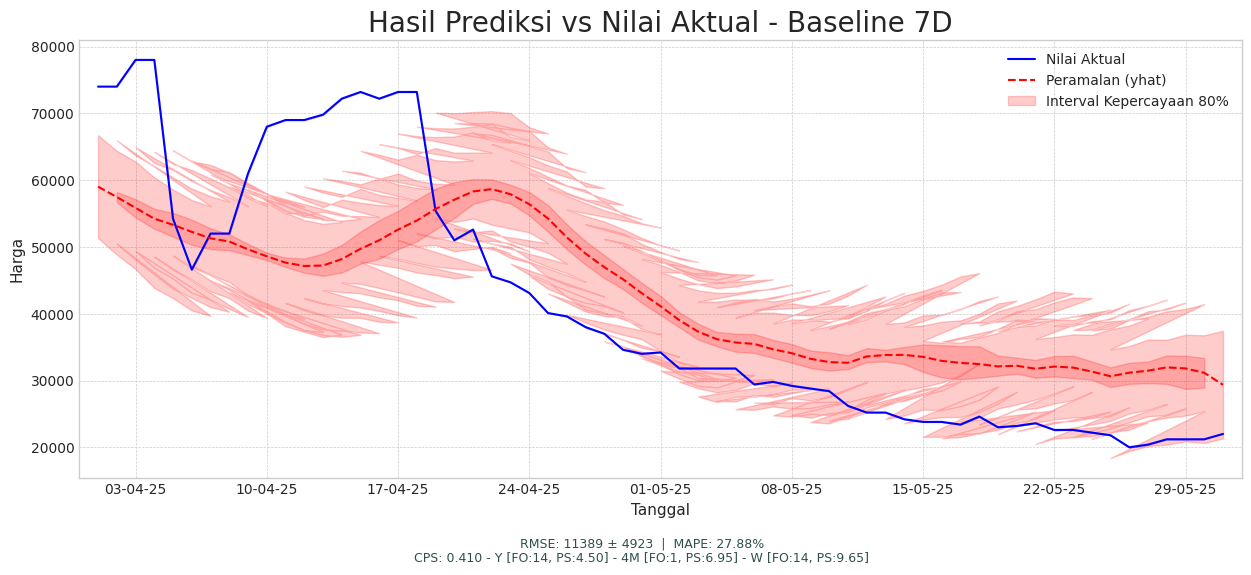

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON_LABEL = "7d"
HORIZON_VAL = "7 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Baseline 30D

Trial 200/200
Optimasi Selesai.
Ditemukan 11 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg      std_rmse       mape    cps  fo365  ps365  \
0      1   197  16841.734533   8753.008439  34.522014  0.020      7   1.45   
1      2    51  16785.612702   8868.833551  34.207952  0.020     10   7.90   
2      3    96  16614.810015   8903.834713  33.678754  0.015     11   1.75   
3      4   138  16399.259808   9400.989867  34.946663  0.455     19   0.25   
4      5     4  15653.891308   9528.181227  31.498672  0.420     20   0.35   
5      6   184  15497.147888   9738.440107  31.293993  0.250     12   0.40   
6      7   178  15243.617350   9866.274382  30.582686  0.255      7   0.35   
7      8   109  14518.402617  10160.701651  27.963089  0.250     11   0.40   
8      9    99  14502.299844  10194.073654  27.225782  0.440     18   0.40   
9     10   100  14411.052950  10237.598027  26.737970  0.265     11   0.55   
10    11    48  14252.601928  11000.676928  25.712850  0.400     13   9.80   

    fo121  ps121  fo7   ps7   skor_cv  
0       5   9.10   19  0.30  0.519721  
1       8   6.25   16  9.95  0.528359  
2       5   0.45   18  2.25  0.535897  
3      11   4.20   19  5.50  0.573257  
4      10   1.20   19  0.95  0.608678  
5      10   0.95   19  3.10  0.628402  
6      11   1.10   19  0.60  0.647240  
7      13   9.15   11  0.65  0.699850  
8       5   0.45   18  0.30  0.702928  
9      12   9.35   18  0.30  0.710399  
10      9   9.10   20  0.20  0.771836


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


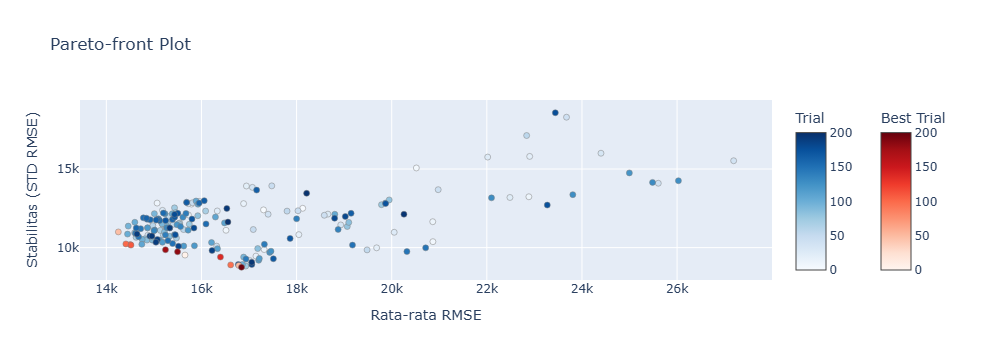

In [ ]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON = "30d"
HORIZON_STR = "30 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Baseline 30D

Parameter yang digunakan:


rank   iter      rmse_avg     std_rmse       mape   cps  fo365  ps365  \
0   1.0  197.0  16841.734533  8753.008439  34.522014  0.02    7.0   1.45   

   fo121  ps121   fo7  ps7   skor_cv  
0    5.0    9.1  19.0  0.3  0.519721


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 18123 ± 9470, MAPE = 33.96%
File metrik per-fold telah disimpan.


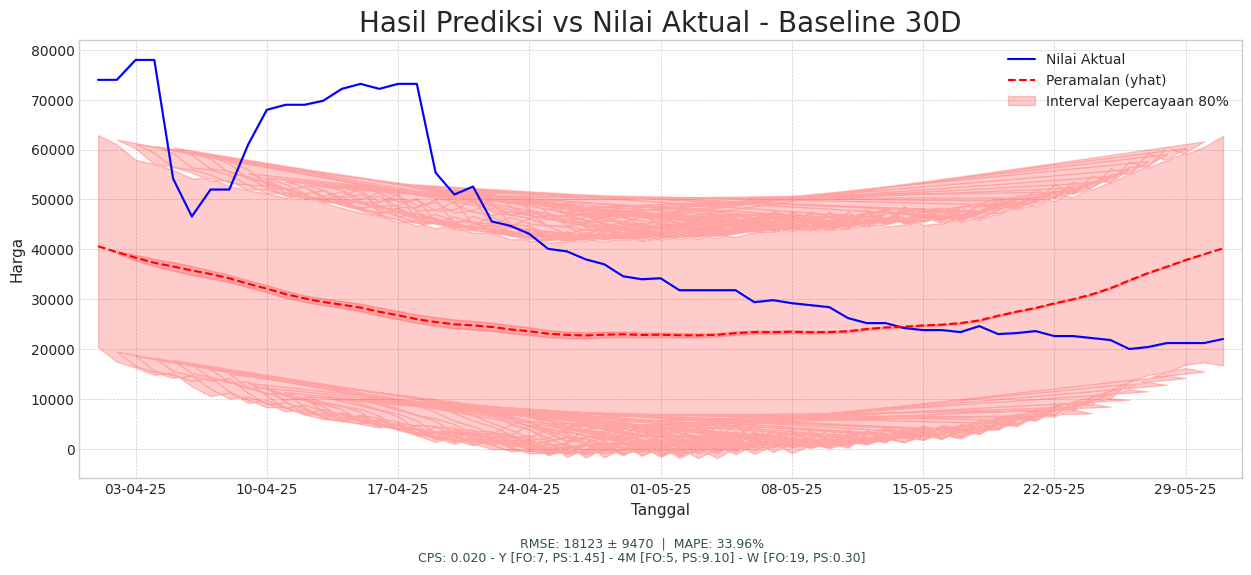

In [18]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "baseline"
HORIZON_LABEL = "30d"
HORIZON_VAL = "30 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

# Model + Holiday

TSCV Model Holiday 1D

Trial 200/200
Optimasi Selesai.
Ditemukan 11 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0      1   145  7815.574669  3744.317871  17.721624  0.490     14   0.35   
1      2   177  7360.563496  3852.770888  16.221930  0.455     15   0.55   
2      3   173  6958.970897  3896.753032  15.179404  0.500     15   0.60   
3      4   139  6793.659006  4234.326161  14.776499  0.440     14   0.60   
4      5   110  6731.723475  4465.949575  14.193280  0.465     14   9.20   
5      6   195  6688.989068  4475.234208  14.147153  0.485     15   3.05   
6      7   198  6556.273686  4528.047868  13.737638  0.485     15   4.45   
7      8   196  6388.929655  4530.010773  13.374738  0.485     16   6.65   
8      9   193  6349.327979  4721.042383  13.267948  0.485     16   4.45   
9     10   124  6341.306603  5515.385822  13.124162  0.480     14   0.60   
10    11   134  6328.072819  5924.197702  12.866181  0.485     16   2.10   

    fo121  ps121  fo7   ps7   hps   skor_cv  
0       4   6.60   19  0.75  4.10  0.479084  
1       3   8.15   20  0.55  2.30  0.523434  
2       8   7.20   18  0.55  5.15  0.559961  
3       6   5.60   17  0.45  4.15  0.623276  
4       5   0.95    8  0.25  9.00  0.663418  
5      12   7.60   20  0.40  2.40  0.669045  
6      12   8.50   18  0.40  2.45  0.690644  
7      12   7.65   20  0.35  2.45  0.709041  
8      12   8.35   20  0.30  1.90  0.743550  
9       5   6.45   18  0.05  5.60  0.869755  
10      6   5.50   13  0.05  4.65  0.936177


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


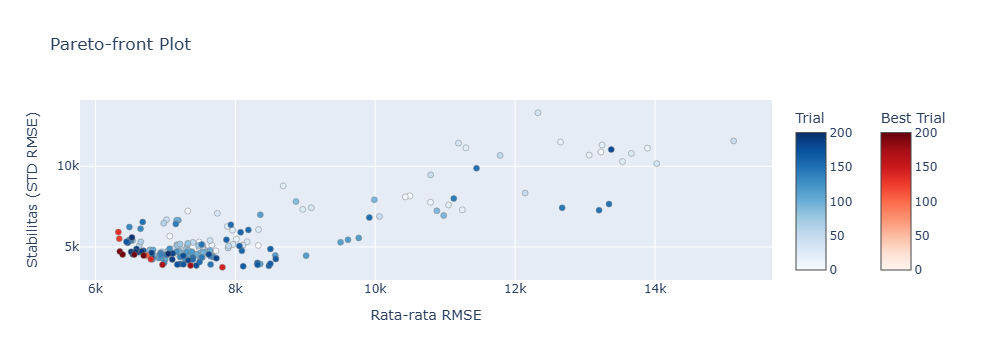

In [23]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Holiday 1D

Parameter yang digunakan:


rank   iter     rmse_avg     std_rmse       mape  cps  fo365  ps365  fo121  \
2   3.0  173.0  6958.970897  3896.753032  15.179404  0.5   15.0    0.6    8.0   

   ps121   fo7   ps7   hps   skor_cv  
2    7.2  18.0  0.55  5.15  0.559961


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 9736 ± 6500, MAPE = 26.41%
File metrik per-fold telah disimpan.


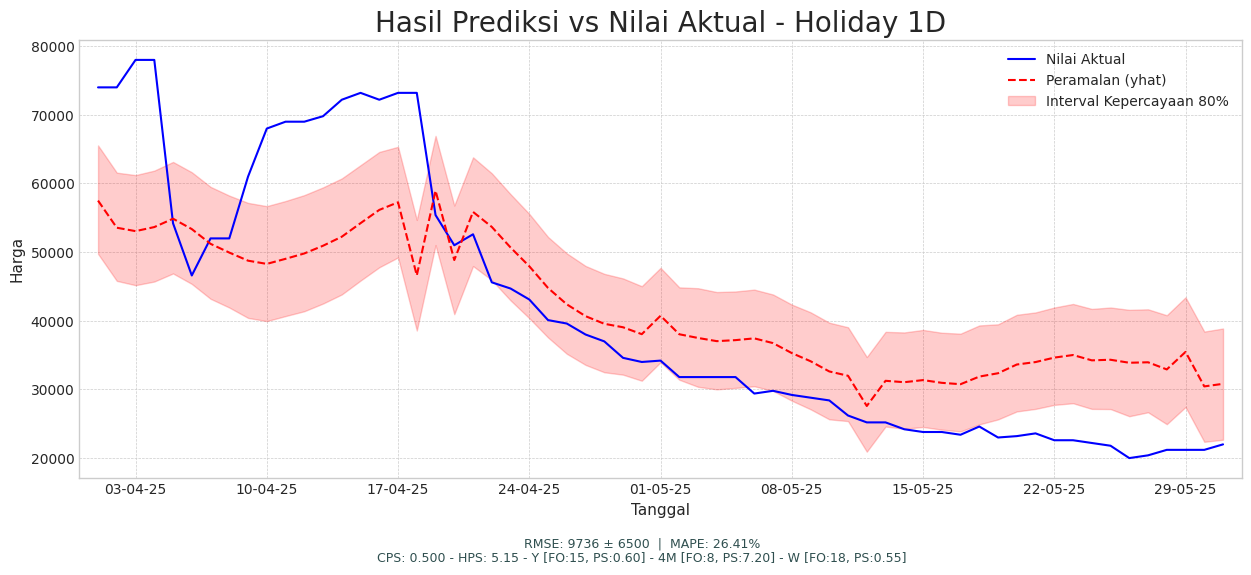

In [29]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[2]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly_custom', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month_custom', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly_custom', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Model Holiday 7D

Trial 200/200
Optimasi Selesai.
Ditemukan 3 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   115  10061.318071  5386.303617  21.429789  0.470     14   5.95   
1     2   130   9924.089730  5451.774862  20.794225  0.480     15   7.20   
2     3     1   8766.973299  5592.724393  17.856385  0.425     14   2.45   

   fo121  ps121  fo7   ps7   hps   skor_cv  
0      1    0.6   20  9.10  4.75  0.535348  
1      2    9.3   18  9.05  8.25  0.549348  
2     17    7.8    8  9.25  2.30  0.637931


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


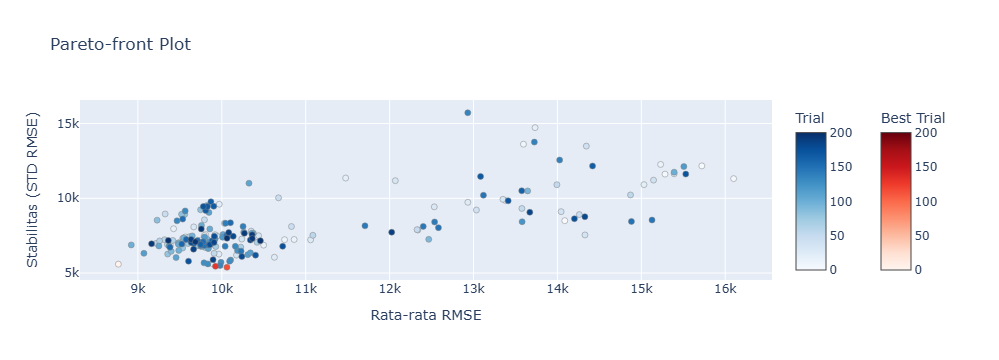

In [30]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON = "7d"
HORIZON_STR = "7 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Holiday 7D

Parameter yang digunakan:


rank   iter      rmse_avg     std_rmse       mape   cps  fo365  ps365  \
0   1.0  115.0  10061.318071  5386.303617  21.429789  0.47   14.0   5.95   

   fo121  ps121   fo7  ps7   hps   skor_cv  
0    1.0    0.6  20.0  9.1  4.75  0.535348


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 11788 ± 5092, MAPE = 28.60%
File metrik per-fold telah disimpan.


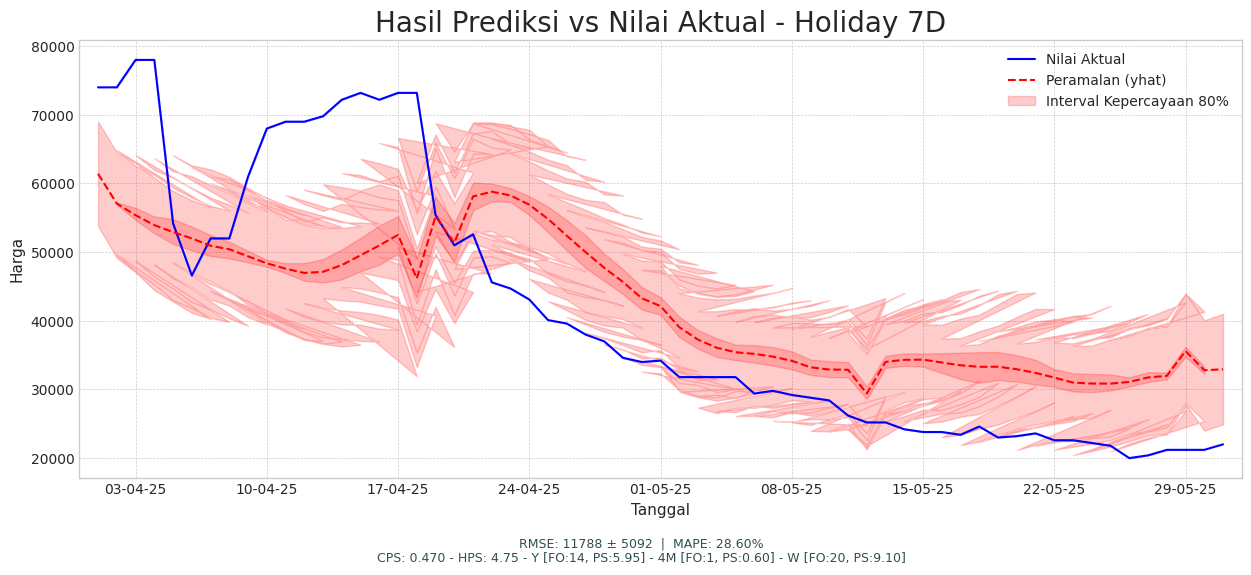

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON_LABEL = "7d"
HORIZON_VAL = "7 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly_custom', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month_custom', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly_custom', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Model Holiday 30D

In [12]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON = "30d"
HORIZON_STR = "30 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Trial 200/200
Optimasi Selesai.
Ditemukan 12 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg      std_rmse       mape    cps  fo365  ps365  \
0      1    24  16979.030713   8807.837083  34.441694  0.015     18   3.65   
1      2   123  16926.363029   8813.802495  34.371595  0.015     19   5.70   
2      3    58  16924.313825   8850.444194  34.095429  0.010     18   4.20   
3      4   185  15544.468554   9817.870318  31.973719  0.265      7   0.50   
4      5    94  15454.548710  10050.088756  31.306358  0.160     16   0.45   
5      6    89  15344.083843  10107.214264  30.595602  0.150     17   0.50   
6      7   140  15031.084860  10167.644873  29.535518  0.150     12   0.50   
7      8   126  14796.115505  10168.601040  29.035885  0.160     19   0.60   
8      9    69  14778.831652  10579.793012  28.526399  0.115     19   1.15   
9     10    99  14739.418522  11186.215527  27.663643  0.185     18   4.70   
10    11   128  14682.866481  11626.232228  27.533582  0.160     12   7.05   
11    12   148  14448.168691  11809.289242  26.633210  0.265     12   6.95   

    fo121  ps121  fo7   ps7   hps   skor_cv  
0       1   1.25   20  4.80  9.15  0.518748  
1       3   1.20   20  5.50  8.60  0.520714  
2       3   3.35   19  6.05  9.50  0.522943  
3      13   6.20   14  8.65  0.45  0.631599  
4       6   8.90   16  4.60  0.10  0.650300  
5       1   9.70   11  4.45  0.10  0.658704  
6      13   8.95    8  9.15  0.65  0.676441  
7       5   9.05    9  8.65  0.30  0.687248  
8       2   9.40    8  5.45  1.30  0.715875  
9       6   9.95    9  4.70  0.95  0.758932  
10     11   9.05    9  8.45  4.35  0.791823  
11     13   8.80    7  8.00  0.65  0.817355


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


Model Holiday 30D

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "holiday"
HORIZON_LABEL = "30d"
HORIZON_VAL = "30 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly_custom', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month_custom', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly_custom', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

Parameter yang digunakan:


rank  iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0   1.0  24.0  16979.030713  8807.837083  34.441694  0.015   18.0   3.65   

   fo121  ps121   fo7  ps7   hps   skor_cv  
0    1.0   1.25  20.0  4.8  9.15  0.518748


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 18817 ± 9235, MAPE = 36.19%
File metrik per-fold telah disimpan.


# Model + Cuaca

TSCV Cuaca

Trial 200/200
Optimasi Selesai.
Ditemukan 13 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0      1    69  7444.988771  4912.583885  16.081381  0.500     13   5.60   
1      2    68  7415.381090  5009.849557  15.960524  0.470     13   5.50   
2      3    66  7391.495630  5032.411538  15.946905  0.470     13   5.60   
3      4    75  7333.440947  5053.389642  15.686467  0.500     12   9.20   
4      5   140  7047.393751  5088.520425  14.916827  0.475     18   8.65   
5      6   184  6970.109730  5215.169736  14.651728  0.470     18   5.30   
6      7   199  6818.332695  5252.388198  14.252899  0.490     19   5.80   
7      8   124  6773.541264  5374.116227  14.146676  0.490     18   8.25   
8      9   119  6736.364552  6090.141490  14.183714  0.485     12   7.85   
9     10   116  6704.806963  6300.048221  13.981653  0.450     19   7.90   
10    11   148  6601.743098  6481.252613  13.344260  0.500     17   8.90   
11    12   149  6377.321630  6741.274302  12.930580  0.500     18   9.10   
12    13   129  6359.674848  6754.622430  12.844785  0.475     18   8.20   

    fo121  ps121  fo7   ps7   rr7  stress_idx7_lag23   skor_cv  
0       2   0.75    7  3.75  5.40               0.05  0.659851  
1       2   2.20    7  3.90  5.45               0.10  0.675602  
2       2   2.00    7  4.50  5.45               0.05  0.680838  
3       1   0.70    8  9.90  9.85               2.65  0.689088  
4       6   0.30   16  0.60  4.55               9.15  0.722043  
5       4   3.60   14  0.45  4.15               0.05  0.748219  
6       2   0.30    8  0.60  5.60               0.45  0.770333  
7       6   0.75   15  0.30  6.55               7.90  0.793398  
8       6   0.45   12  1.80  4.85               1.40  0.904069  
9       6   1.20   14  0.10  6.10               6.45  0.939632  
10      4   0.30   15  0.05  2.75               9.35  0.981749  
11      4   0.25   17  0.05  2.95               8.35  1.057070  
12      5   0.50   15  0.05  4.50               1.60  1.062102


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


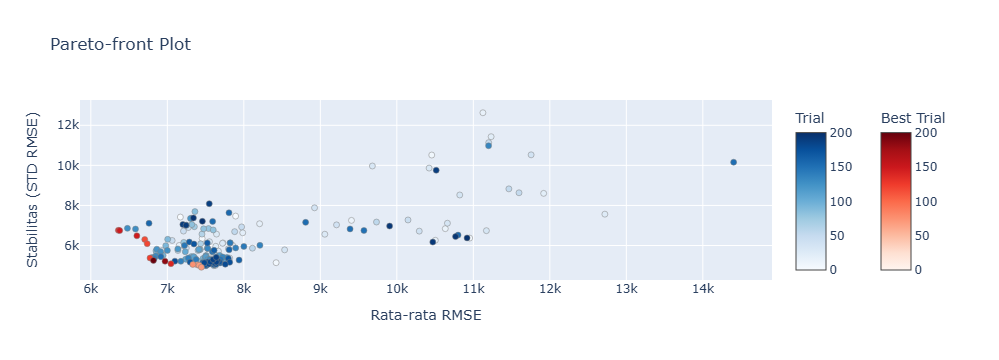

In [16]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Cuaca Lengkap 1D

Parameter yang digunakan:


rank  iter     rmse_avg     std_rmse       mape  cps  fo365  ps365  fo121  \
0   1.0  69.0  7444.988771  4912.583885  16.081381  0.5   13.0    5.6    2.0   

   ps121  fo7   ps7  rr7  stress_idx7_lag23   skor_cv  
0   0.75  7.0  3.75  5.4               0.05  0.659851


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 8960 ± 5065, MAPE = 23.17%
File metrik per-fold telah disimpan.


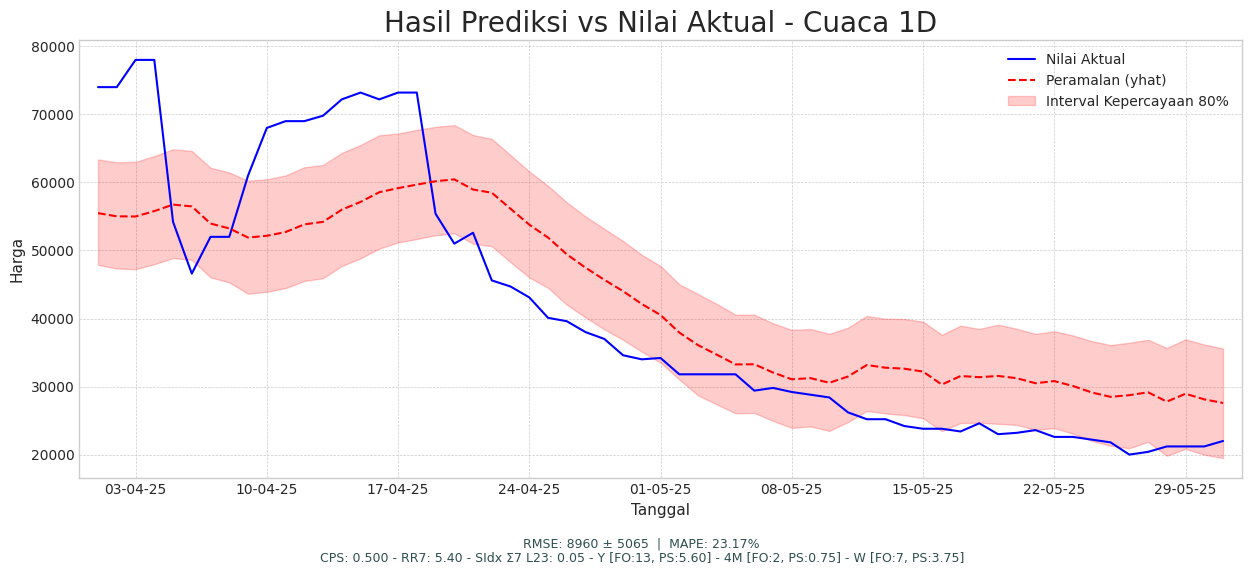

In [22]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Cuaca 7D

Trial 200/200
Optimasi Selesai.
Ditemukan 7 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   170  10105.826601  5038.417235  21.551017  0.475     14   7.60   
1     2    65   9648.649602  5069.985121  20.311573  0.480     13   1.55   
2     3    84   9628.100067  6644.909298  20.079399  0.495     11   1.50   
3     4   162   9501.417749  7160.836111  19.136621  0.480     12   2.10   
4     5     9   9359.088233  7304.740031  18.860338  0.430      9   4.85   
5     6    61   9227.694591  7397.621545  19.050951  0.475     13   5.55   
6     7   188   8838.896452  7759.663865  17.275435  0.475     15   2.95   

   fo121  ps121  fo7   ps7   rr7  stress_idx7_lag23   skor_cv  
0      4   0.35   12  8.45  1.10               6.80  0.498566  
1      4   0.30   11  8.15  9.10               7.70  0.525461  
2      6   0.75    9  6.00  7.60               8.35  0.690158  
3     20   9.90   11  6.00  8.45               8.10  0.753660  
4      8   0.40   11  0.30  6.85               3.60  0.780497  
5      4   0.10   12  0.10  9.60               5.25  0.801676  
6      5   0.55    3  0.45  8.95               2.55  0.877900


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


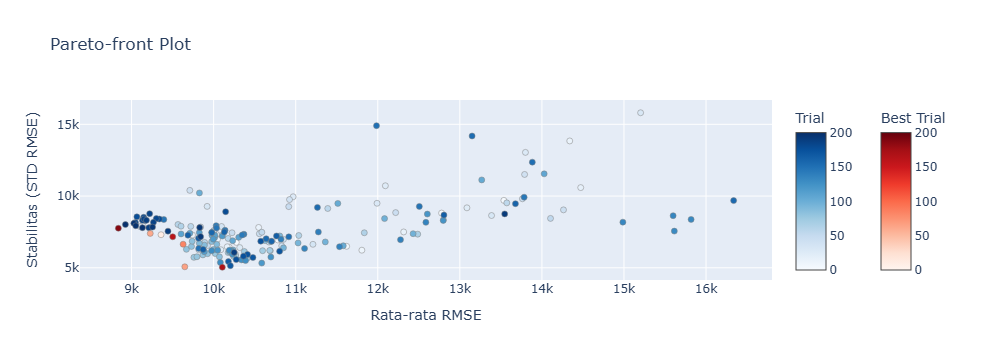

In [41]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON = "7d"
HORIZON_STR = "7 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Cuaca 7D

Parameter yang digunakan:


rank   iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0   1.0  170.0  10105.826601  5038.417235  21.551017  0.475   14.0    7.6   

   fo121  ps121   fo7   ps7  rr7  stress_idx7_lag23   skor_cv  
0    4.0   0.35  12.0  8.45  1.1                6.8  0.498566


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 11001 ± 3937, MAPE = 28.16%
File metrik per-fold telah disimpan.


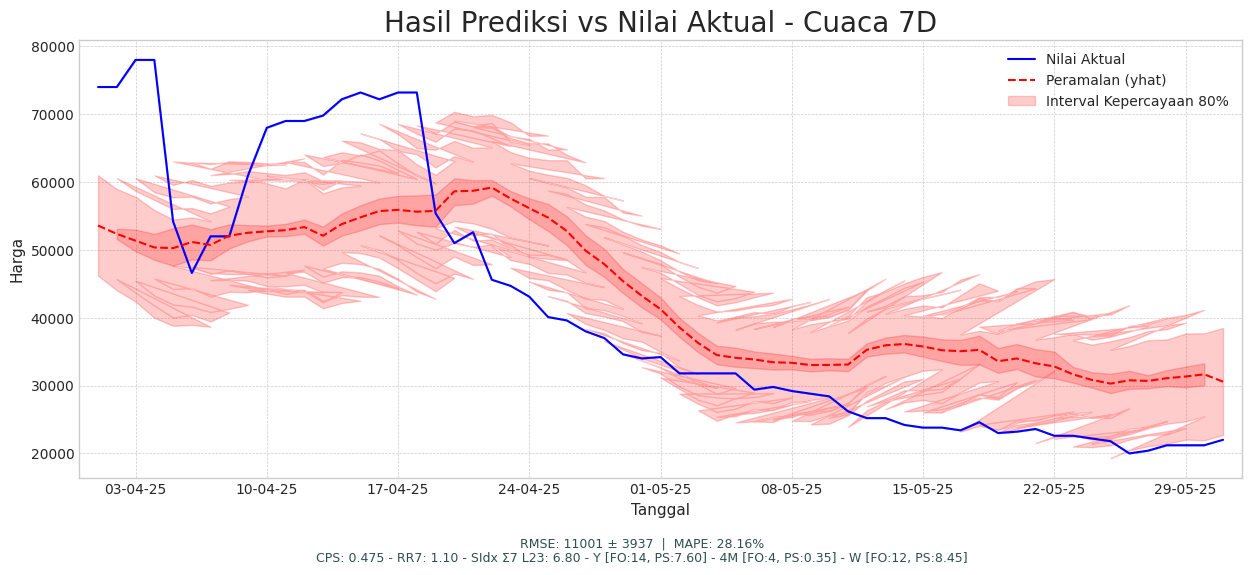

In [23]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON_LABEL = "7d"
HORIZON_VAL = "7 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

TSCV Cuaca 30D

Trial 200/200
Optimasi Selesai.
Ditemukan 8 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   160  14806.517675  6984.953814  30.544151  0.020     18   8.05   
1     2   161  14750.726188  7071.263749  30.448459  0.020     16   9.95   
2     3   171  14528.303137  7098.883974  29.783351  0.015     18   9.55   
3     4   148  14426.001659  7105.633154  28.320571  0.005     17   9.10   
4     5   129  14421.821183  7164.593181  28.284209  0.005     19   0.90   
5     6   100  14368.206410  7200.904286  29.596389  0.015     20   0.05   
6     7   110  14334.037902  7221.150383  29.344682  0.015     16   0.60   
7     8   145  14072.716890  7237.633024  27.489699  0.005     18   0.05   

   fo121  ps121  fo7   ps7   rr7  stress_idx7_lag23   skor_cv  
0     10   2.30   11  3.80  4.30               2.55  0.471749  
1     17   2.15   13  3.80  5.20               7.50  0.479384  
2      9   2.60   11  3.80  5.20               2.55  0.488624  
3     10   1.00   12  3.40  4.95               3.10  0.492557  
4     10   3.85    8  6.85  1.10               3.65  0.496788  
5      5   5.00   16  6.05  1.05               4.40  0.501169  
6      2   4.70   14  4.55  0.70               5.65  0.503776  
7     11   1.25   12  3.45  4.05               3.05  0.514302


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


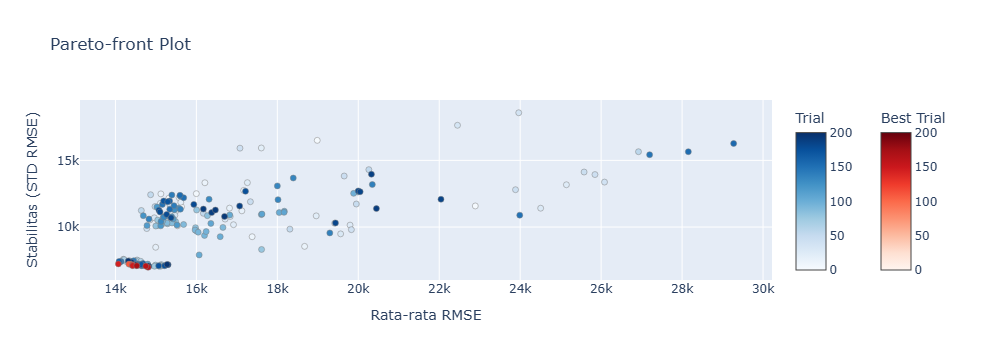

In [45]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON = "30d"
HORIZON_STR = "30 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model Cuaca 30D

Parameter yang digunakan:


rank   iter      rmse_avg     std_rmse       mape   cps  fo365  ps365  \
0   1.0  160.0  14806.517675  6984.953814  30.544151  0.02   18.0   8.05   

   fo121  ps121   fo7  ps7  rr7  stress_idx7_lag23   skor_cv  
0   10.0    2.3  11.0  3.8  4.3               2.55  0.471749


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 18626 ± 7897, MAPE = 39.85%
File metrik per-fold telah disimpan.


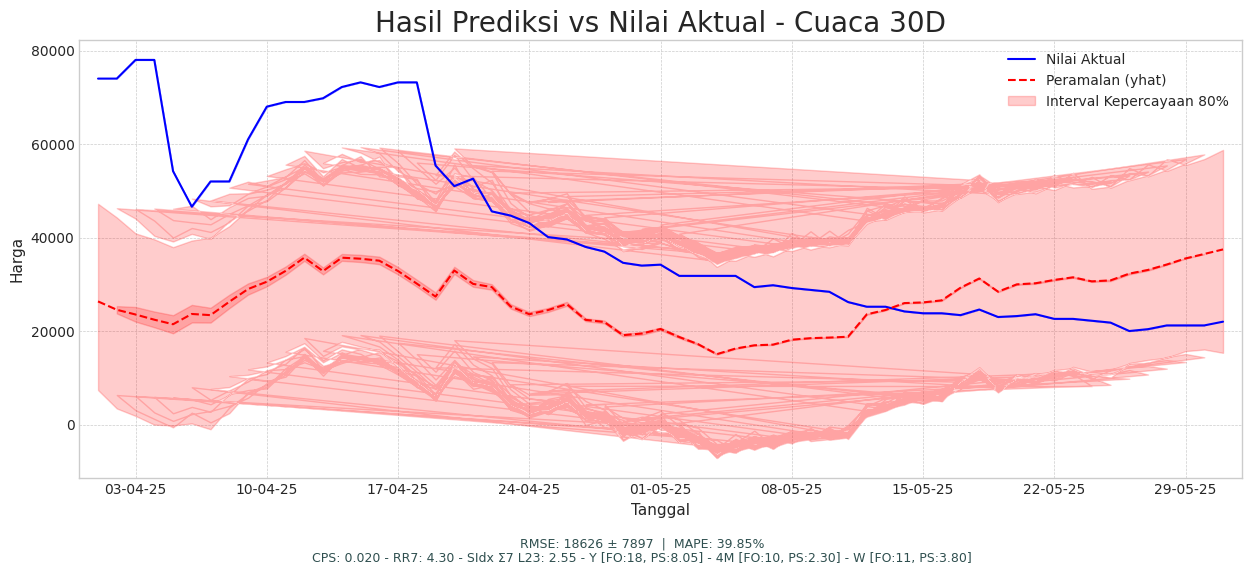

In [24]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "cuaca"
HORIZON_LABEL = "30d"
HORIZON_VAL = "30 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

# Model Holiday+Cuaca

TSCV HC 1D

In [21]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Trial 200/200
Optimasi Selesai.
Ditemukan 15 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0      1   128  7364.615151  4627.555325  15.673953  0.430     17   1.20   
1      2   167  7258.307909  4749.483564  15.620487  0.460     13   6.60   
2      3    85  7167.483151  4858.348067  15.172272  0.400     17   4.35   
3      4   172  7056.483441  4872.618368  14.958548  0.455     19   6.85   
4      5    95  6875.146620  4915.493103  14.547233  0.460     18   4.25   
5      6   192  6835.610717  5115.348548  14.412952  0.395     18   4.75   
6      7   190  6805.953228  5177.203099  14.361056  0.485     18   6.45   
7      8    70  6801.452835  5664.291808  14.369652  0.460     19   3.90   
8      9    66  6654.885954  5828.163149  13.706330  0.355     17   5.25   
9     10    71  6594.790208  5886.744465  13.803872  0.420     19   3.60   
10    11   165  6350.169247  6259.211913  13.042996  0.420     19   6.85   
11    12   163  6327.045754  6294.412421  13.026329  0.420     15   7.55   
12    13    69  6278.872838  6407.154345  12.849081  0.425     19   5.25   
13    14   121  6271.680171  6430.095084  12.856973  0.450     19   4.20   
14    15    76  6237.380608  6479.012026  12.755167  0.415     19   4.50   

    fo121  ps121  fo7   ps7   hps   rr7  stress_idx7_lag23   skor_cv  
0       3   5.55   20  0.55  5.10  3.30               4.55  0.628350  
1       4   8.75   20  0.50  4.45  0.10               3.75  0.654351  
2       5   8.55   20  0.50  4.20  2.15               7.50  0.677832  
3       4   5.40   15  0.45  5.25  8.15               3.80  0.690517  
4       5   9.00   19  0.35  5.35  3.00              10.00  0.714966  
5       3   8.45   20  0.25  5.00  3.30               7.05  0.748338  
6       3   6.20   19  0.20  5.10  8.90               5.45  0.760687  
7       2   5.85   19  0.10  4.65  3.45               7.15  0.832806  
8       3   8.60   19  0.10  4.70  9.65               8.95  0.875772  
9       2   7.40   19  0.10  4.70  3.35               7.20  0.892636  
10      5   6.75   11  0.10  4.45  2.90               6.15  0.985676  
11      5   2.40   14  0.05  2.10  3.95               3.10  0.994842  
12      2   5.90   19  0.05  4.80  3.30               8.90  1.020431  
13      2   7.35   18  0.05  5.95  0.65               8.65  1.025259  
14      3   8.55   20  0.05  4.00  3.45               8.90  1.038739


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


Model HC 1D

In [25]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

Parameter yang digunakan:


rank   iter     rmse_avg     std_rmse       mape   cps  fo365  ps365  \
0   1.0  128.0  7364.615151  4627.555325  15.673953  0.43   17.0    1.2   

   fo121  ps121   fo7   ps7  hps  rr7  stress_idx7_lag23  skor_cv  
0    3.0   5.55  20.0  0.55  5.1  3.3               4.55  0.62835


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 9791 ± 6013, MAPE = 27.13%
File metrik per-fold telah disimpan.


TSCV HC 7D

Trial 200/200
Optimasi Selesai.
Ditemukan 4 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   169  9670.488447  5567.204881  20.534390  0.475     10   6.80   
1     2   188  9414.055720  5833.208493  19.616211  0.460     10   8.65   
2     3    83  9172.838413  5887.723355  18.723257  0.455     11   4.60   
3     4    90  8992.116813  5927.993298  18.328981  0.450     10   4.95   

   fo121  ps121  fo7   ps7   hps   rr7  stress_idx7_lag23   skor_cv  
0      2   5.95   15  3.90  6.30  9.45               1.90  0.575690  
1      2   5.60   14  4.15  7.85  9.85               1.50  0.619628  
2      2   5.30   16  4.45  0.50  9.20               2.25  0.641865  
3      2   6.55   16  4.55  4.60  7.95               5.05  0.659243


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


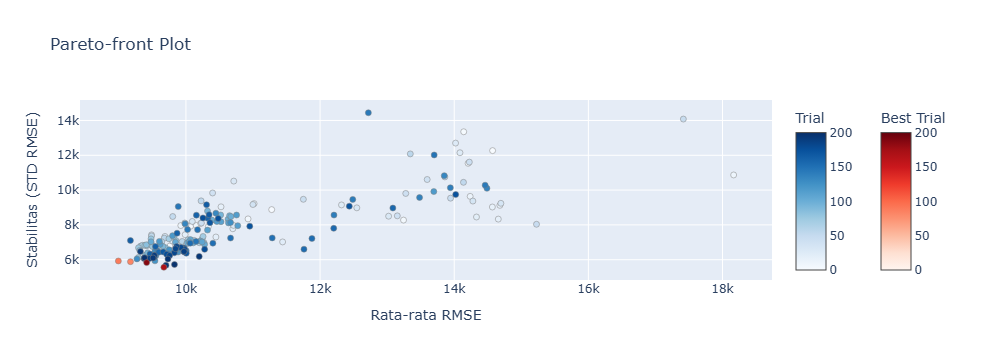

In [23]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON = "7d"
HORIZON_STR = "7 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_30': trial.suggest_int('fo_30', 1, 20),
        'ps_30': trial.suggest_float('ps_30', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("monthly_custom", 30.5, params['fo_30'], params['ps_30'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Model HC 7D

In [26]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON_LABEL = "7d"
HORIZON_VAL = "7 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

Parameter yang digunakan:


rank   iter     rmse_avg     std_rmse      mape    cps  fo365  ps365  \
0   1.0  169.0  9670.488447  5567.204881  20.53439  0.475   10.0    6.8   

   fo121  ps121   fo7  ps7  hps   rr7  stress_idx7_lag23  skor_cv  
0    2.0   5.95  15.0  3.9  6.3  9.45                1.9  0.57569


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 12050 ± 4151, MAPE = 30.71%
File metrik per-fold telah disimpan.


TSCV HC 30D

In [27]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON = "30d"
HORIZON_STR = "30 days"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05),
        'rr7': trial.suggest_float('rr7', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor("RR7", params['rr7'])
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
        'rr7': p['rr7'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Trial 200/200
Optimasi Selesai.
Ditemukan 5 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter      rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   193  14612.792126  7001.558929  30.363131  0.020     12   9.35   
1     2   108  14310.852032  7019.607806  29.558750  0.015     15   8.30   
2     3   178  14027.701504  7060.914933  27.473396  0.005     12   8.90   
3     4   182  13991.416444  7215.956512  27.414802  0.005     11   8.95   
4     5   176  13880.582112  7276.902204  27.048744  0.005     11   8.95   

   fo121  ps121  fo7   ps7   hps   rr7  stress_idx7_lag23   skor_cv  
0      5   8.60   10  7.25  5.05  3.65               7.55  0.479139  
1      5   2.45    9  4.15  9.00  5.35               0.35  0.490509  
2      5   7.25    9  4.80  9.40  5.80               0.50  0.503355  
3      5   7.90    9  6.55  5.40  3.75               9.75  0.515742  
4      5   8.45    9  7.35  5.60  3.80               7.80  0.524251


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


Model HC 30 Days

Parameter yang digunakan:


rank   iter      rmse_avg     std_rmse       mape   cps  fo365  ps365  \
0   1.0  193.0  14612.792126  7001.558929  30.363131  0.02   12.0   9.35   

   fo121  ps121   fo7   ps7   hps   rr7  stress_idx7_lag23   skor_cv  
0    5.0    8.6  10.0  7.25  5.05  3.65               7.55  0.479139


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 18675 ± 7950, MAPE = 39.64%
File metrik per-fold telah disimpan.


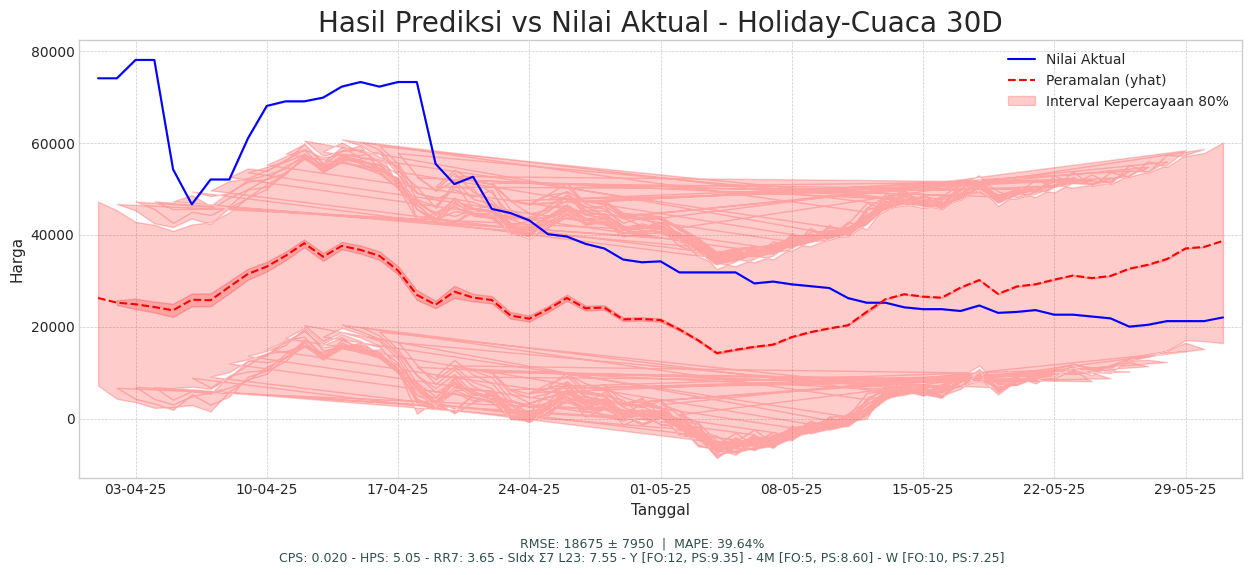

In [27]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Holiday-Cuaca"
HORIZON_LABEL = "30d"
HORIZON_VAL = "30 days"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        holidays_prior_scale=best_params['hps']
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')
    m.add_regressor('RR7', best_params['rr7'])
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"HPS: {best_params['hps']:.2f} - "
        f"RR7: {best_params['rr7']:.2f} - "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()

# Temp

In [ ]:
# Calculate min, max, and average for each weather feature
cuaca_stats = df.describe().loc[['min', 'max', 'mean']]

# Display the calculated statistics
print("Statistik Cuaca (Min, Max, Average):")
display(cuaca_stats.style.format("{:.2f}"))

# Hitung baris dengan kondisi tertentu
kondisi_tn = df['TN'] <= 15
kondisi_tx = df['TX'] >= 32
kondisi_nol_rr = df['RR'] == 0
kondisi_nol_ss = df['SS'] == 0
kondisi_nol_ffx = df['FF_X'] == 0

# Gabungkan semua kondisi
kondisi_gabungan = kondisi_tn | kondisi_tx | kondisi_nol_rr | kondisi_nol_ss | kondisi_nol_ffx

# Hitung jumlah baris yang memenuhi setidaknya satu kondisi
jumlah_baris_kondisi = df[kondisi_gabungan].shape[0]

# Hitung jumlah baris untuk setiap kondisi secara terpisah
jumlah_tn_kebawah = df[kondisi_tn].shape[0]
jumlah_tx_keatas = df[kondisi_tx].shape[0]
jumlah_rr_nol = df[kondisi_nol_rr].shape[0]
jumlah_ss_nol = df[kondisi_nol_ss].shape[0]
jumlah_ffx_nol = df[kondisi_nol_ffx].shape[0]

# Tampilkan hasilnya
print("\nJumlah baris dengan kondisi tertentu:")
print(f"Jumlah baris dimana Tn <= 15: {jumlah_tn_kebawah}")
print(f"Jumlah baris dimana Tx >= 32: {jumlah_tx_keatas}")
print(f"Jumlah baris dimana RR == 0: {jumlah_rr_nol}")
print(f"Jumlah baris dimana SS == 0: {jumlah_ss_nol}")
print(f"Jumlah baris dimana ffx == 0: {jumlah_ffx_nol}")
print(f"Jumlah baris yang memenuhi setidaknya satu dari kondisi di atas: {jumlah_baris_kondisi}")

Statistik Cuaca (Min, Max, Average):



Jumlah baris dengan kondisi tertentu:
Jumlah baris dimana Tn <= 15: 3
Jumlah baris dimana Tx >= 32: 51
Jumlah baris dimana RR == 0: 586
Jumlah baris dimana SS == 0: 32
Jumlah baris dimana ffx == 0: 0
Jumlah baris yang memenuhi setidaknya satu dari kondisi di atas: 629


Trial 200/200
Optimasi Selesai.
Ditemukan 5 kandidat model terbaik di Pareto Front.

Kandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):


rank  iter     rmse_avg     std_rmse       mape    cps  fo365  ps365  \
0     1   178  7211.595405  4878.041713  15.209359  0.500     11   9.85   
1     2    70  7183.577429  5332.621112  14.926667  0.390     11   3.20   
2     3   172  6797.471112  5473.668406  13.937769  0.490     10   9.35   
3     4    51  6721.924449  6743.355900  14.167077  0.395     18   8.85   
4     5   171  6414.960342  6841.694559  13.181532  0.500     18   9.35   

   fo121  ps121  fo30  ps30  fo7   ps7   hps  stress_idx7_lag23   skor_cv  
0      1   4.60     2  3.90   16  1.10  7.05               4.35  0.676416  
1      3   0.75    16  7.50    9  9.95  2.85               5.90  0.742335  
2      1   4.60     8  3.90   16  0.40  6.40               4.60  0.805251  
3      1   4.60    13  3.95    8  7.20  1.30               7.35  1.003188  
4      1   4.15     8  3.60   11  0.45  6.35               2.65  1.066522


Plot Pareto Front (Trade-off antara RMSE dan Stabilitas):


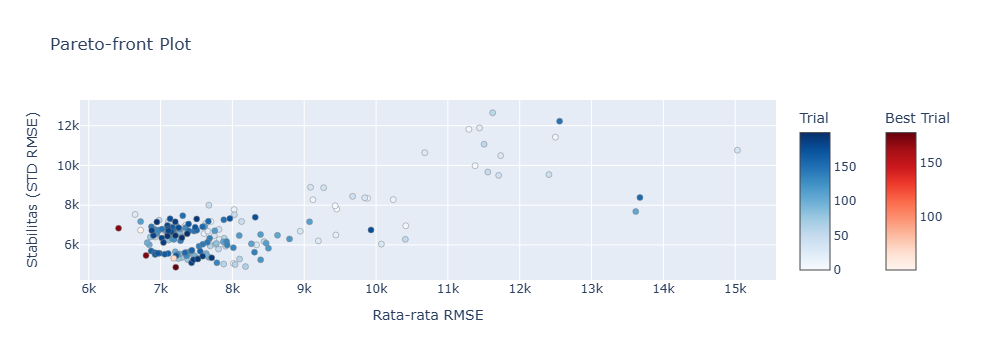

In [20]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Temp-Holiday-Cuaca"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 0.5, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 20),
        'ps_365': trial.suggest_float('ps_365', 0.05, 10, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 20),
        'ps_121': trial.suggest_float('ps_121', 0.05, 10, step=0.05),
        'fo_30': trial.suggest_int('fo_30', 1, 20),
        'ps_30': trial.suggest_float('ps_30', 0.05, 10, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 20),
        'ps_7': trial.suggest_float('ps_7', 0.05, 10, step=0.05),
        'hps': trial.suggest_float('hps', 0.05, 10, step=0.05),
        'stress_idx7_lag23': trial.suggest_float('stress_idx7_lag23', 0.05, 10, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("monthly_custom", 30.5, params['fo_30'], params['ps_30'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.add_country_holidays(country_name='ID')
    m.holiday_prior_scale=params['hps']
    m.add_regressor("stress_idx7_lag23", params['stress_idx7_lag23'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo30': p['fo_30'], 'ps30': p['ps_30'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
        'hps': p['hps'],
        'stress_idx7_lag23': p['stress_idx7_lag23'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

In [21]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "Temp-Holiday-Cuaca"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[0]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('monthly', 30.5, int(best_params['fo30']), best_params['ps30'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])
    m.add_country_holidays(country_name='ID')
    m.holiday_prior_scale=best_params['hps']
    m.add_regressor('stress_idx7_lag23', best_params['stress_idx7_lag23'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} | "
        f"HPS: {best_params['hps']:.2f} | "
        f"SIdx Σ7 L23: {best_params['stress_idx7_lag23']:.2f} | "
        f"Yearly FO: {int(best_params['fo365'])} PS: {best_params['ps365']:.2f} | "
        f"4 Month FO: {int(best_params['fo121'])} PS: {best_params['ps121']:.2f} | "
        f"Monthly FO: {int(best_params['fo30'])} PS: {best_params['ps30']:.2f} | "
        f"Weekly FO: {int(best_params['fo7'])} PS: {best_params['ps7']:.2f}"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=16)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=300, bbox_inches='tight')
    plt.show()

Parameter yang digunakan:


rank   iter     rmse_avg     std_rmse       mape  cps  fo365  ps365  fo121  \
0   1.0  178.0  7211.595405  4878.041713  15.209359  0.5   11.0   9.85    1.0   

   ps121  fo30  ps30   fo7  ps7   hps  stress_idx7_lag23   skor_cv  
0    4.6   2.0   3.9  16.0  1.1  7.05               4.35  0.676416


Melatih model dengan parameter terbaik pada data uji...
Menjalankan cross-validation pada data uji...

Metrik Rata-rata Final: RMSE = 8954 ± 6144, MAPE = 23.46%
File metrik per-fold telah disimpan.


In [ ]:
import optuna, logging, warnings
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import pandas as pd
from optuna.visualization import plot_param_importances, plot_optimization_history
from sklearn.metrics import mean_squared_error


logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "extrem"
HORIZON = "1d"
HORIZON_STR = "1 day"

def objective(trial):
    print(f"\rTrial {trial.number + 1}/{200}", end="")

    params = {
        'cps': trial.suggest_float('cps', 0.005, 50, step=0.005),
        'fo_365': trial.suggest_int('fo_365', 1, 50),
        'ps_365': trial.suggest_float('ps_365', 0.05, 100, step=0.05),
        'fo_121': trial.suggest_int('fo_121', 1, 50),
        'ps_121': trial.suggest_float('ps_121', 0.05, 100, step=0.05),
        'fo_7': trial.suggest_int('fo_7', 1, 50),
        'ps_7': trial.suggest_float('ps_7', 0.05, 100, step=0.05)
    }

    m = Prophet(
        changepoint_prior_scale=params['cps'],
        seasonality_mode='multiplicative',
        yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False,
    )
    m.add_seasonality("yearly_custom", 365.25, params['fo_365'], params['ps_365'])
    m.add_seasonality("4_month_custom", 121.75, params['fo_121'], params['ps_121'])
    m.add_seasonality("weekly_custom", 7, params['fo_7'], params['ps_7'])
    m.fit(df_tscv)
    
    df_cv = cross_validation(
        m, initial='930 days', period='15 days', horizon=HORIZON_STR, parallel='processes'
    )

    # Hitung metrik per cutoff
    perf_per_fold = []
    for cutoff_date, group_df in df_cv.groupby('cutoff'):
        y_true = group_df['y']
        y_pred = group_df['yhat']

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = (
            np.mean(np.abs((y_true - y_pred) / y_true[y_true != 0])) * 100
            if (y_true != 0).any()
            else np.nan
        )

        perf_per_fold.append({'cutoff': cutoff_date, 'RMSE': rmse, 'MAPE': mape})

    df_p = pd.DataFrame(perf_per_fold)
    trial.set_user_attr("mape", df_p['MAPE'].mean())
    trial.set_user_attr("rmse", df_p['RMSE'].mean())
    trial.set_user_attr("std_rmse", df_p['RMSE'].std()) 

    return df_p['RMSE'].mean(), df_p['RMSE'].std()

study = optuna.create_study(
    directions=['minimize','minimize'],
    sampler=optuna.samplers.TPESampler(seed=42, n_startup_trials=50)
)
study.optimize(objective, n_trials=200, n_jobs=-1)
print("\nOptimasi Selesai.")

# --- Pengolahan Hasil (Menggunakan Coefficient of Variation) ---
import optuna.visualization as vis

# 1. Ambil SEMUA kandidat terbaik dari Pareto Front
best_candidates = study.best_trials
print(f"Ditemukan {len(best_candidates)} kandidat model terbaik di Pareto Front.")

data_candidates = []
for t in best_candidates:
    p = t.params
    row = {
        'iter': t.number,
        'rmse_avg': t.values[0],
        'std_rmse': t.values[1],
        'mape': t.user_attrs.get('mape', np.nan),
        'cps': p['cps'],
        'fo365': p['fo_365'], 'ps365': p['ps_365'],
        'fo121': p['fo_121'], 'ps121': p['ps_121'],
        'fo7': p['fo_7'], 'ps7': p['ps_7'],
    }
    data_candidates.append(row)
df_candidates = pd.DataFrame(data_candidates)


# 3. Hitung Coefficient of Variation (CV) sebagai skor ranking
df_candidates['skor_cv'] = df_candidates['std_rmse'] / df_candidates['rmse_avg'].replace(0, 1e-6)

# 4. Urutkan DataFrame berdasarkan skor CV terendah
df_ranked = df_candidates.sort_values(by='skor_cv').reset_index(drop=True)
df_ranked.insert(0, 'rank', range(1, len(df_ranked) + 1))

print("\nKandidat Terbaik (Diurutkan Berdasarkan Coefficient of Variation Terendah):")
display(df_ranked)

file_name = f"cv_best_trials_{VARIAN}_{HORIZON}.xlsx"
df_ranked.to_excel(file_name, index=False)

df_all_trials = study.trials_dataframe()
df_all_trials.to_excel(f"all_trials_{VARIAN}_{HORIZON}.xlsx", index=False)

print("\nPlot Pareto Front (Trade-off antara RMSE dan Stabilitas):")
fig_pareto = vis.plot_pareto_front(study, target_names=["Rata-rata RMSE", "Stabilitas (STD RMSE)"])
fig_pareto.data[0].update(marker=dict(cmin=0,cmax=200))
fig_pareto.data[1].update(marker=dict(cmin=0.0,cmax=200))
fig_pareto.show()
fig_pareto.write_image(f"pareto_front_{VARIAN}_{HORIZON}.png")

Trial 152/200

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import datetime as dt
import logging, warnings

# Disable warning/logging
logging.disable(logging.CRITICAL)
warnings.filterwarnings('ignore')

# --- Konfigurasi ---
VARIAN = "extrem"
HORIZON_LABEL = "1d"
HORIZON_VAL = "1 day"

ranked_candidates =  pd.read_excel(f"cv_best_trials_{VARIAN}_{HORIZON_LABEL}.xlsx")
best_params = ranked_candidates.iloc[5]
print("Parameter yang digunakan:")
display(best_params.to_frame().T)

if best_params is not None:
    m = Prophet(
        seasonality_mode='multiplicative',
        changepoint_prior_scale=best_params['cps'],
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    m.add_seasonality('yearly', 365.25, int(best_params['fo365']), best_params['ps365'])
    m.add_seasonality('4_month', 121.75, int(best_params['fo121']), best_params['ps121'])
    m.add_seasonality('weekly', 7, int(best_params['fo7']), best_params['ps7'])

    # --- Fit dan Cross Validation ---
    print("\nMelatih model dengan parameter terbaik pada data uji...")
    m.fit(df_pred)
    
    print("Menjalankan cross-validation pada data uji...")
    df_cv = cross_validation(
        m, initial='1185 days', period='1 days', horizon=HORIZON_VAL, parallel='processes'
    )

    # --- Hitung RMSE dan MAPE per Fold ---
    fold_metrics = []
    for cutoff, group in df_cv.groupby('cutoff'):
        y_true = group['y']
        y_pred = group['yhat']
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mape = np.mean(np.abs((y_true - y_pred) / y_true.replace(0, np.nan))) * 100
        fold_metrics.append({'cutoff': cutoff, 'RMSE': rmse, 'MAPE': mape})

    df_fold_metrics = pd.DataFrame(fold_metrics)
    mean_rmse = df_fold_metrics['RMSE'].mean()
    std_rmse = df_fold_metrics['RMSE'].std()
    mean_mape = df_fold_metrics['MAPE'].mean()

    print(f"\nMetrik Rata-rata Final: RMSE = {mean_rmse:.0f} ± {std_rmse:.0f}, MAPE = {mean_mape:.2f}%")

    # --- Simpan Hasil ---
    df_fold_metrics.to_excel(f"fold_metrics_{VARIAN}_{HORIZON_LABEL}.xlsx", index=False)
    print("File metrik per-fold telah disimpan.")

    # --- Visualisasi ---
    plt.figure(figsize=(15, 6))
    sns.lineplot(data=df_cv, x='ds', y='y', label='Nilai Aktual', color='blue')
    sns.lineplot(data=df_cv, x='ds', y='yhat', label='Peramalan (yhat)', color='red', linestyle='--')

    plt.fill_between(
        df_cv['ds'], df_cv['yhat_lower'], df_cv['yhat_upper'],
        color='red', alpha=0.2, label='Interval Kepercayaan 80%'
    )

    plt.xticks(rotation=0)
    plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
    plt.xlim(dt.datetime(2025, 3, 31), dt.datetime(2025, 6, 1)) 
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=7))
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%y'))

    info_text = (
        f"RMSE: {mean_rmse:.0f} ± {std_rmse:.0f}  |  MAPE: {mean_mape:.2f}%\n"
        f"CPS: {best_params['cps']:.3f} - "
        f"Y [FO:{int(best_params['fo365'])}, PS:{best_params['ps365']:.2f}] - "
        f"4M [FO:{int(best_params['fo121'])}, PS:{best_params['ps121']:.2f}] - "
        f"W [FO:{int(best_params['fo7'])}, PS:{best_params['ps7']:.2f}]"
    )

    plt.title(f'Hasil Prediksi vs Nilai Aktual - {VARIAN.title()} {HORIZON_LABEL.title()}', fontsize=20)
    plt.xlabel('Tanggal', fontsize=11)
    plt.ylabel('Harga', fontsize=11)
    plt.legend()
    plt.subplots_adjust(bottom=0.15)
    plt.figtext(0.5, 0.01, info_text, ha='center', fontsize=9, color='darkslategrey')

    plt.savefig(f"plot_prediksi_{VARIAN}_{HORIZON_LABEL}.png", dpi=600, bbox_inches='tight')
    plt.show()